In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from tqdm.auto import tqdm
from time import sleep
import scienceplots
import subprocess
pd.set_option('display.max_columns', None)
plt.style.use(['default','notebook']) #plt.style.use(['science','notebook'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [2]:
columns = ['sur', 'sur2', 't', 'e1','e2','g1','g2','a1','i1','i2','i','spin1h','spintot',
            'beta','vp','spin1e','spin1q','spin2e','spin2q','spin2h','htot','m1','R1','m2',
            'R2','a2','m3','Roche1','R1_pow','type1','type2','type3','beta2','gamma','gamma2','flag'] #columns in output file
df_columns = ['N'] + columns #columns used in dataframes

def get_first_line(file_path: str) -> str: #get first line 

    with open(file_path) as f:
        return f.readline()
#
def get_last_line(file_path: str) -> str: #faster way to get last line
    last_line=''
    with open(file_path, 'rb') as file:
        try:
            file.seek(-2, os.SEEK_END)
            while file.read(1) != b'\n':
                file.seek(-2, os.SEEK_CUR)
        except OSError:
            file.seek(0)

        last_line = file.readline().decode()
        return last_line

def is_within_percent(a,b, eps):
    '''returns whether a is within eps percentage of b
    :param eps: the proportion that you want a to be within b
    '''
    return abs(a/b - 1) <= eps
    
def cut_output_files(directory):
    #function to get final periods of all txt files in 'directory'
    #output in numpy array of logP in days

    for filename in os.listdir(directory):
        if filename.endswith('.txt') and filename.startswith('output'):
            this_file = os.path.join(directory, filename) #stores FULL filename

            first_line = get_first_line(this_file) #get first line
            last_line = get_last_line(this_file) #get last line
            
            N = filename.split('.txt')[0].split('_')[1] #get the output file number
            with open(directory+'cut_files/first_last_{}.txt'.format(N), 'w') as f:
                f.write(first_line)
                f.write(last_line)
def Roche_limit(q):
    '''
    Function to get Roche Limit of specified mass ratios (q)
    :param q: mass ratio
    :return: returns the Roche Limit (RHS of Eqn.1 from Naoz+2014)
    '''
    num1,num2=0.49,0.6;
    return num1*np.power(q,2./3.)/(0.6* np.power(q,2./3.)+np.log(1+np.sqrt(q)));

directory = '/Users/bijan1339/Desktop/Research/OSPEStellarEv_updated/outputs/'
#get_final_periods(directory)  
def maybe_float(s):
    """
    Converts object type to float if it can be made a float
    :param s: The object (any type)
    :return: float(s) or s depending on whether it can be made float or not
    """
    try:
        return float(s)
    except (ValueError, TypeError):
        return s
def find_line(file,type1,type2=-1):
    """
    Goes through OSPE output file and finds last instance where there is an 
    inner binary with star types specified above (types from SSE).
    :param file: The first argument (string)
    :param type1: The second argument (integer)
    :param type2: The third argument. -1 means that the type can be any type (integer)
    :return: last line of occurence in file; line split into list and converted numbers to float (list)
    """
    if type2 == -1:
        for line in reversed(open(file).readlines()):
            line = [maybe_float(x) for x in line.split()]

            if (line[-6] == type1 or line[-7] == type1):
                return line
                break
    elif type1 == -1:
        for line in reversed(open(file).readlines()):
            line = [maybe_float(x) for x in line.split()]

            if (line[-6] == type2 or line[-6] == type2):
                return line
                break
                
    else: 
        for line in reversed(open(file).readlines()):
            line = [maybe_float(x) for x in line.split()]
            
            if ( (line[-6] == type1) and (line[-7] == type2) ) or ( (line[-6] == type2) and (line[-7] == type1) ): #order doesnt matter:
                return line
                break
def get_m1_condition(df):
    return ( (df['N'].astype(int)>1000) & (df['N'].astype(int)<=2000) ) #only returns 1m intial mass runs
def get_cassini_conditions(df,within=0.05):
    return ( 
        (df['Spin1P'] <= (1.+ within)*df['Omega_p1']) & (df['Spin1P'] >=(1. - within)*df['Omega_p1'])
            )
k2 = 4*np.pi*np.pi

# Inner Binary Analyses

## Concatenate Restart Files 

In [622]:
#GETTING RESTART FILENAMES
directory = '/Users/bijan1339/Desktop/Research/Final_Output8/'
restart_directory = '/Users/bijan1339/Desktop/Research/Final_Output8/Restart_Output/'

#Get list or restart output files
restart_files = [x for x in os.listdir(restart_directory) if 'Re' in x]

#concatting old with restarted files
for this_restart_file in restart_files:

    n = int(this_restart_file.split('.')[0].split('_')[1])

    # Define the names of the two files to be concatenated
    file1 = directory + f'output_{n}.txt'
    file2 = restart_directory + this_restart_file

    # Open the files in read mode
    f1 = open(file1, "r")
    f2 = open(file2, "r")

    # Read the contents of the files
    contents1 = f1.read()
    contents2 = f2.read()

    # Concatenate the contents of the files
    concatenated_contents = contents1 + contents2

    # Define the name of the output file
    output_file = directory + f'output_{n}.txt'

    # Open the output file in write mode
    f_out = open(output_file, "w")

    # Write the concatenated contents to the output file
    f_out.write(concatenated_contents)

    # Close the files
    f1.close()
    f2.close()
    f_out.close()



## Shorten Output Files (Bash)


In [623]:
%%bash

cd /Users/bijan1339/Desktop/Research/


#python3 cut_intermediate_lines.py -dir /Users/bijan1339/Desktop/Research/Final_Output/Restart_Output/ -filestart outputRe_ -start 7000 -stop 8000
python3 cut_intermediate_lines.py -dir /Users/bijan1339/Desktop/Research/Final_Output8/ -filestart output_  -start 8000 -stop 9000




/Users/bijan1339/Desktop/Research/Final_Output8/ output_ 8000 9000


## Making First/Last Dataframes

In [684]:
###############################################
###########   MAKING DATAFRAME(s)  ############
###############################################

#FUNCTIONS TO ADD COLUMNS TO END OF DATAFRAME
def get_inner_period_row(df: pd.DataFrame):
    '''returns VECTORIZED period column in DAYS from df '''
    return np.sqrt((df['a1']**3) / (df['m1'] + df['m2']) )*365.25
def get_outer_period_row(df: pd.DataFrame):
    '''returns VECTORIZED period column in DAYS from df '''
    return np.sqrt((df['a2']**3) / (df['m1'] + df['m2'] + df['m3']) )*365.25
def get_logg(df: pd.DataFrame, G = k2):
    '''returns log(g) for m1,m2 from df row'''
    g1 = G*df['m1']/(df['R1']*df['R1'])
    g2 = G*df['m2']/(df['R2']*df['R2'])
    return [np.log10(g1), np.log10(g2)]
def get_Omega_p(df: pd.DataFrame ):
    beta = df['beta']*np.pi/180.
    beta2 = df['beta2']*np.pi/180.
    omega_1 = (4*np.pi/df['P_in'] ) / (np.cos(beta) + (1/np.cos(beta)) )   
    omega_2 = (4*np.pi/df['P_in'] ) / (np.cos(beta2) + (1/np.cos(beta2)) )   
    return [2*np.pi/omega_1,2*np.pi/omega_2] #returns expected spin periods in days

def get_spin_periods(df: pd.DataFrame):
    
    spin1P_radyr = np.sqrt(df['spin1h']**2.+df['spin1e']**2.+df['spin1q']**2.)
    spin2P_radyr = np.sqrt(df['spin2h']**2.+df['spin2e']**2.+df['spin2q']**2.)
    spin1P = 2.*np.pi*365.25/spin1P_radyr
    spin2P = 2.*np.pi*365.25/spin2P_radyr
    return [spin1P,spin2P]


def make_dataframes(directory : str = '/Users/bijan1339/Desktop/Research/Final_Output/',
                    start : int = 8000, stop : int =9000) -> tuple:
    """
    Generates appends initial and final lines of output files to data frames

    Args:
        directory (str): directory with output files. 
        start (int): minimum n (output_n.txt)
        stop (int): maximum n 

    Returns:
        initial, final (tuple): initial, final contain first, last line dataframes without any conditions
    """    
    
    #columns in output file
    
    initial = pd.DataFrame(columns=df_columns) #initialize dfs
    final = pd.DataFrame(columns=df_columns)

    not_finished=[]
    didnt_start=[]
    for filename in os.listdir(directory):
        this_file = os.path.join(directory, filename) #stores FULL filename
        
        n = filename.split('_')[-1].split('.')[0]

        if (  filename.endswith('.txt') and (filename.startswith('output_') or filename.startswith('concatenated_')) and 
            ( (start <= int(n) <= stop) ) and os.stat(this_file).st_size != 0.
        ):
            #n = filename.split('_')[-1].split('.')[0]
            
            first_line = get_first_line(this_file)#.replace('\x00','') #get first line
            last_line = get_last_line(this_file)#.replace('\x00','') #get last line 

            first_line, last_line = first_line.split('\t'), last_line.split('\t')
            first_line, last_line  = [x.strip() for x in first_line],[x.strip() for x in last_line] #remove white spaces (' ' and '\n')
            #first_line, last_line  = [float(x) for x in first_line[:-1]],[float(x) for x in first_line[:-1]]
            first_line.insert(0,n),last_line.insert(0,n)

            """
            a = float(last_line[df_columns.index('a1')]) #store final SMA (in AU)
            a2 = float(last_line[df_columns.index('a2')])
            e = float(last_line[df_columns.index('e1')]) #store final e (in AU)
            e2 = float(last_line[df_columns.index('e2')]) #store final e (in AU)
            R1,R2 = float(last_line[df_columns.index('R1')]), float(last_line[columns.index('R2')])
            m1,m2 = float(last_line[df_columns.index('m1')]), float(last_line[columns.index('m2')])
            t = float(last_line[df_columns.index('t')])
            P = np.sqrt(a**3 / (m1+m2) )*365.25
            
            Roche1=Roche_limit(m1/m2)
            Roche2=Roche_limit(m2/m1)
            Roche1_criteria = R1 > (a*(1-e)*Roche1)
            Roche2_criteria = R2 > (a*(1-e)*Roche2)
            tidal_locking = (e <= 5e-5 and P*365.25<=7.) #and float(last_line[columns.index('sur')])== 4. #tidal locking if sur==4
            time_criteria = t >= 1e10 # check if until time completion
            epsilon_criteria = (a*e2)/(a2*(1-e2**2)) > 0.1 # essentially stability criteria
            major_criteria = first_line==last_line
            
            #end_criteria = last_line[-1] =='END'
            unfinished = not time_criteria and not (Roche1_criteria or Roche2_criteria or epsilon_criteria or tidal_locking)
            finished =  last_line[-1] == 'END' or float(last_line[3]) > 10e9
            """
            initial.loc[len(initial)]=first_line
            final.loc[len(final)]=last_line

    #default columns to float
    for i in range(1,len(final.columns)-1):
        final.iloc[:, i] = final.iloc[:, i].astype(float)
        initial.iloc[:, i] = initial.iloc[:, i].astype(float)
    

    #Correcting Dtypes
    initial['N'], final['N'] = initial['N'].astype(int), final['N'].astype(int)
    initial['flag'], final['flag'] = initial['flag'].astype(str), final['flag'].astype(str)
    final['sur'], final['sur2'] = final['sur'].astype(int), final['sur2'].astype(int)
    initial['sur'], initial['sur2'] = initial['sur'].astype(int), initial['sur2'].astype(int)
    final['type1'], final['type2'], final['type3'] = final['type1'].astype(int), final['type2'].astype(int), final['type3'].astype(int)
    initial['type1'], initial['type2'], initial['type3'] = initial['type1'].astype(int), initial['type2'].astype(int), initial['type3'].astype(int)

    #ADDING USEFUL COLUMNS AT END OF DFs
    final['P_in'], final['P_out'] = get_inner_period_row(final), get_outer_period_row(final)
    initial['P_in'], initial['P_out'] = get_inner_period_row(initial), get_outer_period_row(initial)

    initial['m1/m2'], final['m1/m2'] = initial['m1'] / initial['m2'], final['m1'] / final['m2']
    
    final['logg_m1'], final['logg_m2'] = get_logg(final)[0], get_logg(final)[1]
    initial['logg_m1'], initial['logg_m2'] = get_logg(initial)[0], get_logg(initial)[1]

    final['Omega_p1'], final['Omega_p2'] = get_Omega_p(final)[0], get_Omega_p(final)[1]
    final['Spin1P'], final['Spin2P'] = get_spin_periods(final)[0], get_spin_periods(final)[1]

    initial['Omega_p1'], initial['Omega_p2'] = get_Omega_p(initial)[0], get_Omega_p(initial)[1]
    initial['Spin1P'], initial['Spin2P'] = get_spin_periods(initial)[0], get_spin_periods(initial)[1]

    initial = initial[initial['N'].isin(final['N'])]
    return initial, final

In [651]:
first = ['8520', '2', '2', '0.000000', '2.976998e-01', '1.000000e-03', '2.417895e+00', '5.494006e+00', '5.849272e+01', '1.686726e+00', '1.264393e+02', '1.281260e+02', '-1.799997e+02', '0.000000e+00', '9.984247e+01', '0.000000e+00', '7.336243e+02', '7.336243e+02', '0.000000e+00', '0.000000e+00', '3.261100e+02', '5.799681e+01', '1.000000e+00', '4.129257e-03', '5.982683e-01', '2.581499e-03', '1.000000e+06', '1.000000e-04', '0.000000e+00', '2.975916e-03', '1.000000', '0.000000', '0.000000', '0.000000e+00', '4.500000e+01', '4.500000e+01', 'FIRST'] 
last = ['8246', '', '1.000000e-03', '-1.392213e+00', '6.881992e-01', '9.250353e-01', '3.221342e+01', '4.589909e+01', '7.811251e+01', '5.949178e+02', '5.949178e+02', '6.988438e-06', '7.811251e+01', '3.212863e-05', '-6.536529e-05', '-7.502983e-03', '-9.155836e-04', '6.062394e+02', '2.776485e+00', '1.000000e+00', '4.861563e-03', '6.404000e-01', '2.824697e-03', '1.000000e+06', '1.000000e-04', '9.555966e-03', '3.553119e-03', '11.000000', '0.000000', '0.000000', '7.143688e-04', '6.371928e+01', '1.730423e+02', 'STEP']

In [698]:
#Fix output files that dont have sur1, sur2, t in first line
output_directory = '/Users/bijan1339/Desktop/Research/Final_Output8/Restart_Output/'
for filename in os.listdir(output_directory):
    
    this_file = os.path.join(output_directory, filename) #stores FULL filename
    n = filename.split('_')[-1].split('.')[0]
    second_line=''
    first_line = get_first_line(this_file)
    
    first_line = first_line.replace('\x00','').split('\t')
    first_line = [maybe_float(x.strip()) for x in first_line]
    
    if len(first_line) == 33: #length should be 36 with sur1,sur2,sur3
        sur1,sur2,t = 2,2,0.
        #change the above params using context of the file
        #if os.stat(this_file).st_size > 7e3: #if the file has more that one line
        with open(this_file, "r") as file:
            file.seek(0)
            _ = file.readline()
            second_line = file.readline().replace('\x00','').split('\t')
            
            if second_line != "": 
                second_line = [maybe_float(x.strip()) for x in second_line]
                sur1,sur2,t = second_line[0],second_line[1],second_line[2]
        
        mod_first_line = [sur1,sur2,t] + first_line
        
        

In [685]:
#initial9,final9 = make_dataframes(directory = '/Users/bijan1339/Desktop/Research/Final_Output9/',start = 9000, stop =9999)
initial8,final8 = make_dataframes(directory = '/Users/bijan1339/Desktop/Research/Final_Output8/',start = 8000, stop =9000)
#initial7,final7 = make_dataframes(directory = '/Users/bijan1339/Desktop/Research/Final_Output/',start = 7000, stop =8000)

ValueError: cannot set a row with mismatched columns

## Making Binary Dataframes

In [509]:
#####################################################################
############       MAKING INNER-BINARY DATAFRAMES      ##############
#####################################################################

def make_inner_binary_dfs(full_outputs_directory: str = '/Users/bijan1339/Desktop/Research/Final_Output/',
                          start: int = 8000, stop: int = 9000) -> pd.DataFrame:
    """
    _summary_

    Args:
        full_outputs_directory (str, optional): _description_. Defaults to '/Users/bijan1339/Desktop/Research/Final_Output/'.

    Returns:
        pd.DataFrame: all_binary_dataframe with the various different types
    """
        
    a = input('Are you sure that you want to run this cell? (y/n)')

    #make sure that the user actually want to run this function
    if a == 'y' or a =='Y':

        print('Ok, Lets Go!')
        columns = ['sur', 'sur2', 't', 'e1','e2','g1','g2','a1','i1','i2','i','spin1h','spintot',
        'beta','vp','spin1e','spin1q','spin2e','spin2q','spin2h','htot','m1','R1','m2',
        'R2','a2','m3','Roche1','R1_pow','type1','type2','type3','beta2','gamma','gamma2','flag']
        all_binary_types = pd.DataFrame(columns= df_columns + ['binary_type']) #initialize df, include last binary_type column

        for filename in tqdm(os.listdir(full_outputs_directory)):
            lines_to_add=[]
            line_MSMS = None
            line_RGRG = None
            line_WDWD = None
            line_RGWD = None
            line_RGMS = None
            line_WDMS = None
            line_RGXX = None
            line_WDXX = None

            
            is_MS1 = True
            is_MS2 = True
            is_RG1 = True
            is_RG1 = True
            is_WD1 = True
            is_WD2 = True
            cant_have_RG = False
            cant_have_WD = False
            
            n = maybe_float( filename.split('_')[-1].split('.')[0] ) #output_n.txt
            this_file = full_outputs_directory + filename
            MS_types = [0.,1.]
            if ( filename.startswith('output_') and (start <= int(n) <= stop) ):
                try:
                    this_df = pd.read_csv(this_file,delimiter='\t',header=None)
                    this_df.columns = columns
                except pd.errors.EmptyDataError: #if file is empty
                    continue
                
                last_row = this_df.iloc[-1,:].values #get last row of df as dataframe
                flag = last_row[-1].strip() #flag at the end
                type1,type2 = int(last_row[-7]),int(last_row[-6]) #final types of stars
                
                #Creating preliminary flags so that we dont need to loop through entire file if not necessary
                if type1 < 5.:
                    is_WD1 = False
                    is_RG1 = False
                if type2 < 5.:
                    is_WD2 = False
                    is_RG2 = False
                
                if type2 < 5. and type1 < 5.: 
                    cant_have_RG = True
                if type2 < 11. and type1 < 11.: 
                    cant_have_WD = True
                
                other_types = [2.,3.,4.,6.,7.,8.,9.,10.,12,.13,14.]
                #get indices of last occurrences for specific binaires
                MSMS_condition = ( (this_df['type1'].isin(MS_types)) & (this_df['type2'].isin(MS_types)) )
                WDWD_condition = ( (this_df['type1'] == 11.) & (this_df['type2'] == 11. ) )
                RGRG_condition = ( (this_df['type1'] == 5.) & (this_df['type2'] == 5. ) )

                RGWD_condition = ( (this_df['type1'] == 5.) & (this_df['type2'] == 11.) )             | ( (this_df['type1']==11.) & (this_df['type2'] == 5.) )         
                RGMS_condition = ( (this_df['type1'] == 5.) & (this_df['type2'].isin(MS_types)) )     | ( (this_df['type1'].isin(MS_types)) & (this_df['type2'] == 5.) )
                WDMS_condition = ( (this_df['type1'] == 11.) & (this_df['type2'].isin(MS_types)) )    | ( (this_df['type1'].isin(MS_types)) & (this_df['type2'] == 11.) )
                RGXX_condition = ( (this_df['type1'] == 5.) & (this_df['type2'].isin(other_types)  )  | (this_df['type2'] == 5.) & (this_df['type1'].isin(other_types)  ) )
                WDXX_condition = ( (this_df['type1'] == 11.) & (this_df['type2'].isin(other_types)  ) | (this_df['type2'] == 11.) & (this_df['type1'].isin(other_types)  ) )
                
                MSMS_indices = np.where(MSMS_condition)[0] #np.array of all indices where condition is met
                RGMS_indices = np.where(RGMS_condition)[0]
                RGWD_indices = np.where(RGWD_condition)[0]
                RGRG_indices = np.where(RGRG_condition)[0]
                WDMS_indices = np.where(WDMS_condition)[0]
                WDWD_indices = np.where(WDWD_condition)[0]
                RGXX_indices = np.where(RGXX_condition)[0]
                WDXX_indices = np.where(WDXX_condition)[0]
                
                MSMS_last_index = np.max(MSMS_indices) if MSMS_indices.size !=0 else None    
                RGMS_last_index = np.max(RGMS_indices) if RGMS_indices.size !=0 else None
                RGWD_last_index = np.max(RGWD_indices) if RGWD_indices.size !=0 else None
                RGRG_last_index = np.max(RGRG_indices) if RGRG_indices.size !=0 else None
                WDMS_last_index = np.max(WDMS_indices) if WDMS_indices.size !=0 else None
                WDWD_last_index = np.max(WDWD_indices) if WDWD_indices.size !=0 else None
                RGXX_last_index = np.max(RGXX_indices) if RGXX_indices.size !=0 else None
                WDXX_last_index = np.max(WDXX_indices) if WDXX_indices.size !=0 else None

                line_MSMS = this_df.iloc[MSMS_last_index] if MSMS_last_index is not None else None
                line_RGMS = this_df.iloc[RGMS_last_index] if RGMS_last_index is not None else None
                line_RGWD = this_df.iloc[RGWD_last_index] if RGWD_last_index is not None else None
                line_RGRG = this_df.iloc[RGRG_last_index] if RGRG_last_index is not None else None
                line_WDMS = this_df.iloc[WDMS_last_index] if WDMS_last_index is not None else None
                line_WDWD = this_df.iloc[WDWD_last_index] if WDWD_last_index is not None else None
                line_RGXX = this_df.iloc[RGXX_last_index] if RGXX_last_index is not None else None
                line_WDXX = this_df.iloc[WDXX_last_index] if WDXX_last_index is not None else None
                
                #append the binary type to the end of the line_XXXX using np.append()
                #add the N values as the first columns
                #check  for below conditions before looking for it in the df
                #make sure that line_to_add is good
                #add WD_ and RG_
                                
                # if is_RG1 and is_RG2:
                #     line_RGRG = find_line(this_file,5.,5.)
                # if is_WD1 and is_WD2:
                #     line_WDWD = find_line(this_file,11.,11.)
                # if (is_RG1 or is_RG2) and (is_WD1 or is_WD2):        
                #     line_RGWD = find_line(this_file,5.,11.)
                # if not cant_have_RG:
                #     # line_RG_ = find_line(this_file,5.,-1)
                #     line_RGMS = find_line(this_file,5.,1.)
                #     if line_RGMS is None: line_RGMS = find_line(this_file,5.,0.)
                # if not cant_have_WD:
                #     # line_WD_ = find_line(this_file,11.,-1)
                #     line_WDMS = find_line(this_file,11.,1.)
                #     if line_WDMS is None: line_WDMS = find_line(this_file,11.,0.)
                                
                if line_MSMS is not None: lines_to_add.append( np.append(line_MSMS, 'MSMS') )
                if line_RGRG is not None: lines_to_add.append( np.append(line_RGRG, 'RGRG') )
                if line_WDWD is not None: lines_to_add.append( np.append(line_WDWD, 'WDWD') ) 
                if line_RGWD is not None: lines_to_add.append( np.append(line_RGWD, 'RGWD') ) 
                if line_RGMS is not None: lines_to_add.append( np.append(line_RGMS, 'RGMS') ) 
                if line_WDMS is not None: lines_to_add.append( np.append(line_WDMS, 'WDMS') ) 
                if line_RGXX is not None: lines_to_add.append( np.append(line_RGXX, 'RGXX') ) 
                if line_WDXX is not None: lines_to_add.append( np.append(line_WDXX, 'WDXX') ) 

                # if line_RG_ is not None and ( line_RG_ != (line_RGWD or line_RGRG or line_RGMS) ):
                #     lines_to_add.append( line_RG_ + ['RG_'] )
                # if line_WD_ is not None and ( line_WD_ != (line_WDWD or line_RGWD or line_WDMS) ):
                #     lines_to_add.append( find_line(this_file,11.,-1) + ['WD_'] )  

                for l in lines_to_add:            
                    try:
                        all_binary_types.loc[len(all_binary_types)]= np.insert(l, 0, int(n))
                    except ValueError:
                        pass
                    
        #ASSIGNING DTYPES TO COLUMNS
        for i in range(1,len(all_binary_types.columns)):
            try: all_binary_types.iloc[:, i] = all_binary_types.iloc[:, i].astype(float)
            except ValueError: continue
            
        all_binary_types['N']=all_binary_types['N'].astype(int)
        
        all_binary_types = all_binary_types.replace(r'\s', '', regex=True)
        all_binary_types = all_binary_types.astype({ 'N': int,
                                                    'flag': 'category',
                                                    'binary_type': 'category'  })

        all_binary_types['P_in'] = get_inner_period_row(all_binary_types)
        all_binary_types['P_out'] = get_outer_period_row(all_binary_types)
        all_binary_types['m1/m2'] = all_binary_types['m1'] / all_binary_types['m2']

        MSMS = all_binary_types.query("binary_type == 'MSMS' and t!=0").drop_duplicates('N',keep='first')   
        WDWD = all_binary_types.query("binary_type == 'WDWD'").drop_duplicates('N',keep='first')      
        RGWD = all_binary_types.query("binary_type == 'RGWD'").drop_duplicates('N',keep='first') 
        WDMS = all_binary_types.query("binary_type == 'WDMS'").drop_duplicates('N',keep='first') 
        RGMS = all_binary_types.query("binary_type == 'RGMS'").drop_duplicates('N',keep='first') 
        RGXX = all_binary_types.query("binary_type == 'RGXX'").drop_duplicates('N',keep='first') 
        WDXX = all_binary_types.query("binary_type == 'WDXX'").drop_duplicates('N',keep='first') 

        
        return (all_binary_types,MSMS, WDWD, RGWD, WDMS, RGMS, RGXX, WDXX)

    else: print('Good Choice!')

In [610]:
directory7 = '/Users/bijan1339/Desktop/Research/Final_Output/'
directory8 = '/Users/bijan1339/Desktop/Research/Final_Output8/'
directory9 = '/Users/bijan1339/Desktop/Research/Final_Output9/'

all_binary_types7,MSMS7, WDWD7, RGWD7, WDMS7, RGMS7, RGXX7, WDXX7 = make_inner_binary_dfs(directory7,7000,8000)
all_binary_types8,MSMS8, WDWD8, RGWD8, WDMS8, RGMS8, RGXX8, WDXX8 = make_inner_binary_dfs(directory8,8000,9000)
all_binary_types9,MSMS9, WDWD9, RGWD9, WDMS9, RGMS9, RGXX9, WDXX9 = make_inner_binary_dfs(directory9,9000,10000)
;

Ok, Lets Go!


100%|██████████| 1001/1001 [00:23<00:00, 42.33it/s]
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_7875/4080913957.py:158: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  try: all_binary_types.iloc[:, i] = all_binary_types.iloc[:, i].astype(float)


''

In [ ]:
#####################################################################
############       MAKING INNER-BINARY DATAFRAMES      ############## 
#####################################################################
#***(OLD)***
"""
def make_inner_binary_dfs(full_outputs_directory: str = '/Users/bijan1339/Desktop/Research/Final_Output/') -> pd.DataFrame:
    
    a = input('Are you sure that you want to run this cell? (y/n)')

    #make sure that the user actually want to run this function
    if a == 'y' or a =='Y':
        print('Ok, Lets Go!')

        all_binary_types = pd.DataFrame(columns= df_columns + ['binary_type']) #initialize df

        for filename in tqdm(os.listdir(full_outputs_directory)):
            lines_to_add=[]
            line_MSMS = None
            line_RGRG = None
            line_WDWD = None
            line_RGWD = None
            line_RGMS = None
            line_WDMS = None
            line_RG_ = None
            line_WD_ = None
    
            
            is_MS1 = True
            is_MS2 = True
            is_RG1 = True
            is_RG1 = True
            is_WD1 = True
            is_WD2 = True
            cant_have_RG = False
            cant_have_WD = False
            
            n = maybe_float( filename.split('_')[-1].split('.')[0] )
            
            this_file = full_outputs_directory + filename
            
            if  (filename.startswith('output_') or filename.startswith('concatenated') and len(last_line) != 1):
                last_line = get_last_line(this_file)#.replace('\x00','') #get last line 
                last_line = last_line.split('\t')
                last_line  = [maybe_float(x.strip()) for x in last_line] #remove white spaces and float all indices

            if  ( 
                (filename.startswith('output_') or filename.startswith('concatenated_')) and 
                (type(n) != str and len(last_line) != 1) and 
                ((8000 <= int(n) <= 9000) )  
                ):


                #Creating preliminary flags so that we dont need to loop through entire file if not necessary

                if last_line[-7] < 5.:
                    is_WD1 = False
                    is_RG1 = False
                if last_line[-6] < 5.:
                    is_WD2 = False
                    is_RG2 = False
                
                if last_line[-6] < 5. and last_line[-7] < 5.: cant_have_RG = True
                if last_line[-6] < 11. and last_line[-7] < 11.: cant_have_WD = True
                    
                if is_MS1 and is_MS2:
                    line_MSMS = find_line(this_file,1.,1.)
                    if line_MSMS is None: line_MSMS = find_line(this_file,0.,1.)
                    if line_MSMS is None: line_MSMS = find_line(this_file,0.,0.)
                        
                if is_RG1 and is_RG2:
                    line_RGRG = find_line(this_file,5.,5.)
                if is_WD1 and is_WD2:
                    line_WDWD = find_line(this_file,11.,11.)
                if (is_RG1 or is_RG2) and (is_WD1 or is_WD2):        
                    line_RGWD = find_line(this_file,5.,11.)
                if not cant_have_RG:
                    # line_RG_ = find_line(this_file,5.,-1)
                    line_RGMS = find_line(this_file,5.,1.)
                    if line_RGMS is None: line_RGMS = find_line(this_file,5.,0.)
                if not cant_have_WD:
                    # line_WD_ = find_line(this_file,11.,-1)
                    line_WDMS = find_line(this_file,11.,1.)
                    if line_WDMS is None: line_WDMS = find_line(this_file,11.,0.)
                                
                if line_MSMS is not None: lines_to_add.append( line_MSMS + ['MSMS'] )
                if line_RGRG is not None: lines_to_add.append( line_RGRG + ['RGRG'] )
                if line_WDWD is not None: lines_to_add.append( line_WDWD + ['WDWD'] ) 
                if line_RGWD is not None: lines_to_add.append( line_RGWD + ['RGWD'] ) 
                if line_RGMS is not None: lines_to_add.append( line_RGMS + ['RGMS'] ) 
                if line_WDMS is not None: lines_to_add.append( line_WDMS + ['WDMS'] ) 

                if line_RG_ is not None and ( line_RG_ != (line_RGWD or line_RGRG or line_RGMS) ):
                    lines_to_add.append( line_RG_ + ['RG_'] )
                if line_WD_ is not None and ( line_WD_ != (line_WDWD or line_RGWD or line_WDMS) ):
                    lines_to_add.append( find_line(this_file,11.,-1) + ['WD_'] )  

                for l in lines_to_add:            
                    try:
                        all_binary_types.loc[len(all_binary_types)]= [int(n)] + l
                    except ValueError:
                        pass

        all_binary_types['P_in'] = get_inner_period_row(all_binary_types)
        all_binary_types['P_out'] = get_outer_period_row(all_binary_types)

        MSMS = all_binary_types.query("binary_type == MSMS and t!=0").drop_duplicates('N',keep='first')   
        WDWD = all_binary_types.query("binary_type == WDWD").drop_duplicates('N',keep='first')      
        RGWD = all_binary_types.query("binary_type == RGWD").drop_duplicates('N',keep='first') 
        WDMS = all_binary_types.query("binary_type == WDMS").drop_duplicates('N',keep='first') 
        RGMS = all_binary_types.query("binary_type == RGMS").drop_duplicates('N',keep='first') 
        RG_ = all_binary_types.query("binary_type == RG_").drop_duplicates('N',keep='first') 
        WD_ = all_binary_types.query("binary_type == WD_").drop_duplicates('N',keep='first') 

        return (all_binary_types,MSMS, WDWD, RGWD, WDMS, RGMS, RG_, WD_)
    
    else: print('Good Choice!')
    """

In [611]:
#cassini_n = [int(x) for x in final['N'] if x in final[get_cassini_conditions(final)]['N'].tolist()]

#remove_from_restart = [1002, 1003, 1010, 1027, 1031, 1065, 1084, 1088, 1165, 1166, 1170, 1202, 1207, 1245, 1247, 
#                        1256, 1259, 1269, 1273, 1280, 1309, 1325, 1389, 1531, 1547, 1556, 1588, 1626, 1631, 1652, 
  #                      1656, 1672, 1675, 1693, 1703, 1723, 1758, 1796, 1807, 1809, 1867, 1876, 1887, 1903, 1994]

def create_dfs(initial: pd.DataFrame, final: pd.DataFrame):
  
  df_final = final.query("(flag == 'END') or (t >= 1e10)")
  df_initial = initial[initial['N'].isin(df_final['N'])]

  unf_final = final.query("(flag != 'END') and (t != 0.)")   
  unf_initial = initial[initial['N'].isin(unf_final['N'])]


  close_df_final = df_final.query("(P_in <= 16) and (sur != 0.) and (t != 0)")
  close_df_initial = df_initial[df_initial['N'].isin(close_df_final['N'])] 

  merged_df_final = df_final[(df_final['sur']==0)]
  merged_df_initial = df_initial[df_initial['N'].isin(merged_df_final['N'])]

  return df_initial, df_final, unf_initial, unf_final, close_df_initial, close_df_final, merged_df_initial, merged_df_final

(df_initial7, df_final7, unf_initial7, unf_final7, 
 close_df_initial7, close_df_final7, merged_df_initial7, merged_df_final7) = create_dfs(initial7, final7)
(df_initial8, df_final8, unf_initial8, unf_final8, 
 close_df_initial8, close_df_final8, merged_df_initial8, merged_df_final8) = create_dfs(initial8, final8)
(df_initial9, df_final9, unf_initial9, unf_final9, 
 close_df_initial9, close_df_final9, merged_df_initial9, merged_df_final9) = create_dfs(initial9, final9)

percent_close7 = (len(close_df_final7) / len(df_final7) ) *100
percent_close8 = (len(close_df_final8) / len(df_final8) ) *100
percent_close9 = (len(close_df_final9) / len(df_final9) ) *100

percent_merged7 = (len(merged_df_final7)/ len(df_final7) ) *100
percent_merged8 = (len(merged_df_final8)/ len(df_final8) ) *100
percent_merged9 = (len(merged_df_final9)/ len(df_final9) ) *100

print(f'Close Binaries 7000: {round(percent_close7,2)}% ({len(close_df_final7)}/{len(df_final7)}) ')
print(f'Close Binaries 8000: {round(percent_close8,2)}% ({len(close_df_final8)}/{len(df_final8)}) ')
print(f'Close Binaries 9000: {round(percent_close9,2)}% ({len(close_df_final9)}/{len(df_final9)}) ')

print(f'Mergers 7: {round(percent_merged7,2)}% ({len(merged_df_final7)}/{len(df_final7)})')
print(f'Mergers 8: {round(percent_merged8,2)}% ({len(merged_df_final8)}/{len(df_final8)})')
print(f'Mergers 9: {round(percent_merged9,2)}% ({len(merged_df_final9)}/{len(df_final9)})')

print('+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+')

print('      {0}  {1}  {2}'.format(7000,8000,9000))
print('---------------------------------------')
print('MSMS: {0:03d}  {1:03d}  {2:03d}'.format(len(MSMS7),len(MSMS8),len(MSMS9)))
print('RGMS: {0:03d}  {1:03d}  {2:03d}'.format(len(RGMS7),len(RGMS8),len(RGMS9)))
print('WDMS: {0:03d}  {1:03d}  {2:03d}'.format(len(WDMS7),len(WDMS8),len(WDMS9)))
print('RGWD: {0:03d}  {1:03d}  {2:03d}'.format(len(RGWD7),len(RGWD8),len(RGWD9)))
print('WDWD: {0:03d}  {1:03d}  {2:03d}'.format(len(WDWD7),len(WDWD8),len(WDWD9)))
print('RGXX: {0:03d}  {1:03d}  {2:03d}'.format(len(RGXX7),len(RGXX8),len(RGXX9)))
print('WDXX: {0:03d}  {1:03d}  {2:03d}'.format(len(WDXX7),len(WDXX8),len(WDXX9)))



Close Binaries 7000: 15.13% (133/879) 
Close Binaries 8000: 0.27% (2/730) 
Close Binaries 9000: 15.97% (127/795) 
Mergers 7: 3.53% (31/879)
Mergers 8: 0.14% (1/730)
Mergers 9: 4.65% (37/795)
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
      7000  8000  9000
---------------------------------------
MSMS: 922  797  858
RGMS: 365  543  450
WDMS: 476  540  295
RGWD: 006  000  084
WDWD: 006  000  100
RGXX: 002  000  022
WDXX: 009  000  111


## Loading in Observations

In [80]:
#Tokovinin Observations
t14a = pd.read_csv("/Users/bijan1339/Desktop/Research/Observations/Tokovinin2014a.tsv",delimiter='\t')
t14a = t14a.drop(t14a.index[[0,1]]).reset_index(drop=True)
t14b = pd.read_csv("/Users/bijan1339/Desktop/Research/Observations/Tokovinin2014b.tsv",delimiter='\t')
t17 = pd.read_csv("/Users/bijan1339/Desktop/Research/Observations/Tokovinin2017.tsv",delimiter='\t')
t17_4obs = pd.read_csv("/Users/bijan1339/Desktop/Research/Observations/Tokovinin2017_4obs.tsv",delimiter='\t')
t17_phi = pd.read_csv("/Users/bijan1339/Desktop/Research/Observations/Tokovinin2017_PHI.tsv",delimiter='\t')


t14b['logP'] = t14b['logP'].replace('     ',None).astype(float)
t14b['M2'] = t14b['M2'].replace('     ',None).astype(float)
t17_4obs['Phi'] = t17_4obs['Phi'].replace('    ',None).astype(float)

#convert all period column to same units in "Period" columns
def all_to_day(row):
    '''returns period in DAYS from df row'''
    if row['x_Per'] == 'y': return row['Per'] * 365.25 #yr to days
    if row['x_Per'] == 'k': return row['Per'] * 1000. * 365.25 #kyr to days
    if row['x_Per'] == 'd': return row['Per'] #alr days
def add_out_params(row,df):
    ID = row['WDS']
    this_outer_row = df[df['WDS'] == ID]
    P_out, e_out, a_out = this_outer_row['P'],this_outer_row['e'],this_outer_row['a']
    try: 
        return (P_out.iloc[0], e_out.iloc[0], a_out.iloc[0]) 
    except IndexError: 
        return [0.0,0.0,0.0]
t17_inner = t17_phi[t17_phi['I/O'] == 'I']
t17_outer = t17_phi[t17_phi['I/O'] == 'O']

#drops systems that have both L11 and 12 level (quintiple++)
t14b_inner = t14b[(t14b['L'] == 11) | (t14b['L'] == 12)].drop_duplicates(subset=['HIP0'], keep=False)
t14b_outer = t14b[(t14b['HIP0'].isin(t14b_inner['HIP0']) ) & (t14b['L'] == 1)]


t14a['Per'] = t14a['Per'].str.strip().astype(float) #convert to float
t14a['Period'] = t14a.apply(lambda row: all_to_day(row), axis=1)

t17['P_out'] = t17.apply(lambda row: add_out_params(row,df=t17_outer)[0], axis=1)
t17['e_out'] = t17.apply(lambda row: add_out_params(row,df=t17_outer)[1], axis=1)
t17['a_out'] = t17.apply(lambda row: add_out_params(row,df=t17_outer)[2], axis=1)

t17_outer.columns=[x+'2' for x in t17_outer.columns]
t17_concat = pd.concat([t17_inner.reset_index(drop=True),t17_outer.reset_index(drop=True)],axis=1) 



## Unfinished Simulations Plots

In [81]:
#################################################
###########  UNFINISHED SIMULATIONS  ############
#################################################

def plot_unfinished(final : pd.DataFrame, title : str = 'Unfinished Current Dist.'): #unf_initial : pd.DataFrame,df_initial: pd.DataFrame, **kwargs):
     #make it so that it shows the previous run
    df = final.query("flag != 'END'")
        

    fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(18, 9))

    ax1.hist(np.log10(df['a1']),histtype='step',density=True,linewidth=1.5,color='b',label='unfinished')

    ax2.hist(df['e1'],histtype='step',density=True,linewidth=1.5,color='b')

    ax3.hist(df['i1'],histtype='step',density=True,linewidth=1.5,color='b')

    ax4.hist(np.log10(df['a2']),histtype='step',density=True,linewidth=1.5,color='b',label='unfinished')

    ax5.hist(df['e2'],histtype='step',density=True,linewidth=1.5,color='b')
    
    ax6.hist(df['m2'],histtype='step',density=True,linewidth=1.5,color='b')

    """ax1.hist(np.log10(unf_initial['a1']),histtype='step',density=True,linewidth=1.5,color='b',label='unfinished')
    ax1.hist(np.log10(df_initial['a1']),histtype='step',density=True,linewidth=1.5,color='gray',label='Finished')

    ax2.hist(unf_initial['e1'],histtype='step',density=True,linewidth=1.5,color='b')
    ax2.hist(df_initial['e1'],histtype='step',density=True,linewidth=1.5,color='gray')

    ax3.hist(unf_initial['i1'],histtype='step',density=True,linewidth=1.5,color='b')
    ax3.hist(df_initial['i1'],histtype='step',density=True,linewidth=1.5,color='gray')

    ax4.hist(np.log10(unf_initial['a2']),histtype='step',density=True,linewidth=1.5,color='b',label='unfinished')
    ax4.hist(np.log10(df_initial['a2']),histtype='step',density=True,linewidth=1.5,color='gray',label='Finished')

    ax5.hist(unf_initial['e2'],histtype='step',density=True,linewidth=1.5,color='b')
    ax5.hist(df_initial['e2'],histtype='step',density=True,linewidth=1.5,color='gray')
    
    ax6.hist(unf_initial['m2'],histtype='step',density=True,linewidth=1.5,color='b')
    ax6.hist(df_initial['m2'],histtype='step',density=True,linewidth=1.5,color='gray')"""
    fig.suptitle(title,fontsize=26)
    
    fig.text(0.04, 0.5, 'Distribution', va='center', rotation='vertical',fontsize=26)

    ax1.set_xlabel('log(a1)',fontsize=13), ax2.set_xlabel('e1',fontsize=13), ax3.set_xlabel('i1',fontsize=13)
    ax4.set_xlabel('log(a1)',fontsize=13), ax5.set_xlabel('e2',fontsize=13), ax6.set_xlabel('m1',fontsize=13)
    ax1.legend(edgecolor='k')
    plt.show()

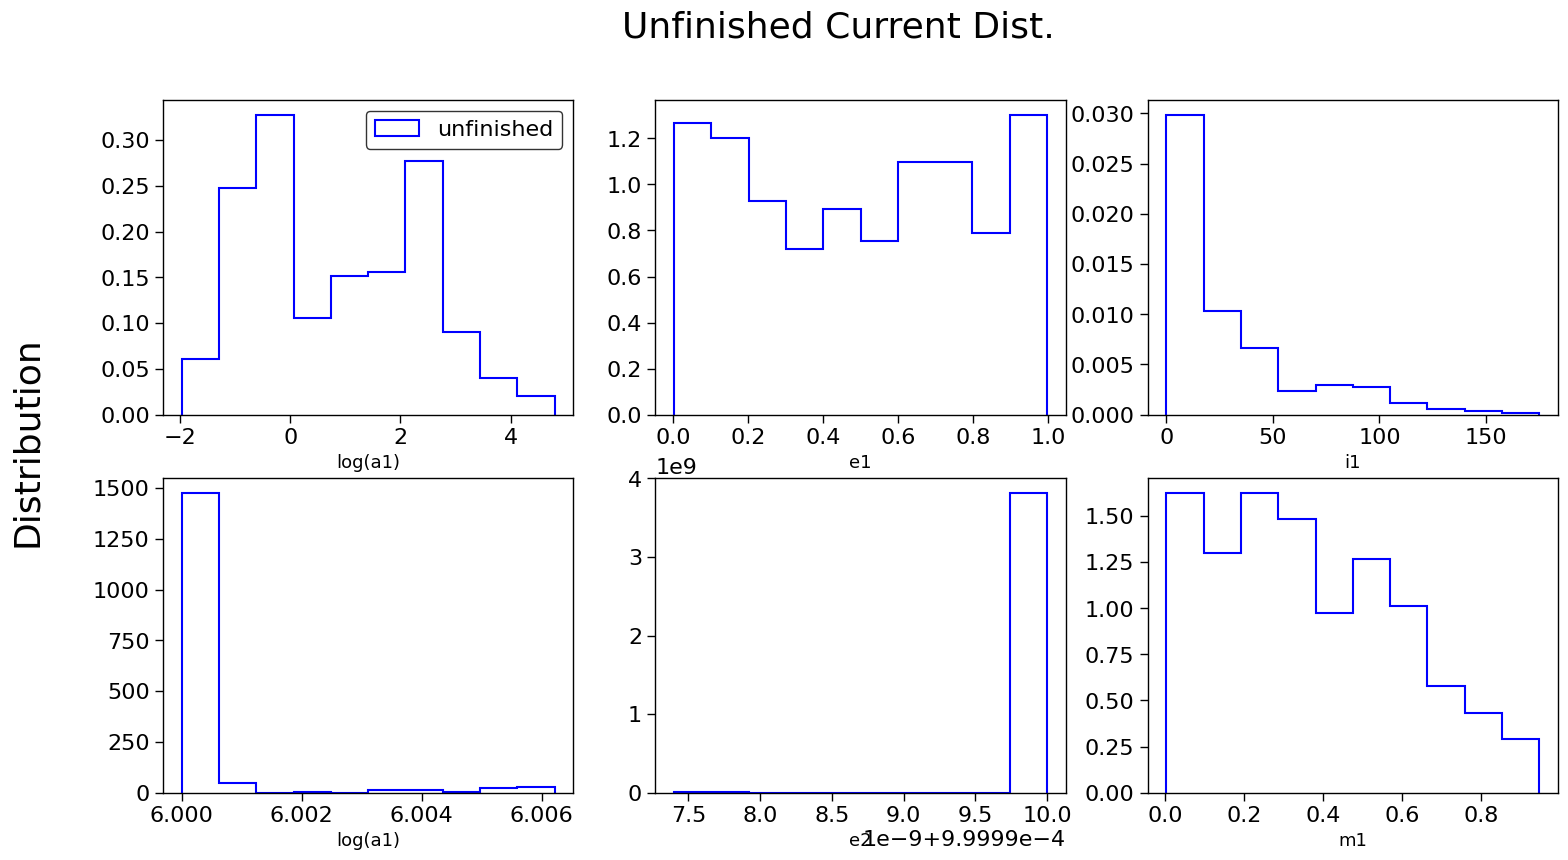

In [574]:
#plot_unfinished(unf_initial7,df_initial7)
plot_unfinished(final8)#,df_initial8)


## Plotting Initial Distributions

In [463]:
def plot_initial_dists(initial,
                       saveFigure=False, initial2 = initial9, save_directory='/Users/bijan1339/Desktop/Research/Figures/IC_dist.pdf'):
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18, 9))
    x1, x11 = np.log10(initial['a1']),np.log10(initial['a2'])
    x111, x1111 = np.log10(initial2['a1']),np.log10(initial2['a2'])
    
    x2, x22,x222 = initial['m1'], initial['m2'], initial['m3']
    x3, x33, x333, x3333 = initial['e1'], initial['e2'], initial2['e1'], initial2['e2']
    #x4, x44, x444, x4444 = np.log10(initial['P_in']), np.log10(initial['P_out']), np.log10(initial2['P_in']), np.log10(initial2['P_out'])
    x4, x44,x444 = initial2['m1'], initial2['m2'], initial2['m3']
    kwargs_hist = {'histtype' :'step','linewidth':1.5,'density':True, 'bins':20}
    c1, c2, c3,c4 = 'blueviolet','deepskyblue','salmon','limegreen'

    ax1.hist(x1,color=c1,label='1 EKL1T',**kwargs_hist)
    ax1.hist(x11,color=c1,label='2 EKL1T',linestyle='--', **kwargs_hist)
    ax1.hist(x111,color=c4,label='1 EKLMS',**kwargs_hist)
    ax1.hist(x1111,color=c4,label='2 EKLMS',linestyle='--', **kwargs_hist)
    
    ax2.hist(x222,color=c3,label='m3',**kwargs_hist)
    ax2.hist(x22,color=c2,label='m2',**kwargs_hist)
    if np.all(x2 == 1.): #if all m1 = 1 
        ax2.axvline(x=1.,color=c1,label='m1',linewidth=2.5)
    else:
        ax2.hist(x2,color=c1,label='m1',**kwargs_hist)

    ax3.hist(x3,color=c1,label='e1',**kwargs_hist)
    ax3.hist(x33,color=c1,label='e2',linestyle='--', **kwargs_hist)
    ax3.hist(x333,color=c4,label='e1',**kwargs_hist)
    ax3.hist(x3333,color=c4,label='e2',linestyle='--', **kwargs_hist)

    ax4.hist(x444,color=c3,label='m3',**kwargs_hist)
    ax4.hist(x44,color=c2,label='m2',**kwargs_hist)
    ax4.hist(x4,color=c1,label='m1',**kwargs_hist)
    
    ax2.text(0.7,0.7,'EKL1T', transform = ax2.transAxes, fontsize=16)
    ax4.text(0.7,0.7,'EKLMS', transform = ax4.transAxes, fontsize=16)
    
    ax1.set_xlabel('log(a) [AU]') 
    ax3.set_xlabel('e'), ax4.set_xlabel('M [M$_\odot$]')
    ax1.set_ylabel('Density'), ax3.set_ylabel('Density')

    ax1.legend(edgecolor='k',ncol=2,fontsize=12), ax2.legend(edgecolor='k',fontsize=12)
    #ax3.legend(edgecolor='k'), ax4.legend(edgecolor='k')

    ax2.set_xlim(   right=np.max(  np.concatenate((x2,x22,x222))  )     )
    if len(x222[x222 > 12.5]) >=1.:  ax2.set_xlim(right= 8)
    ax2.set_xlim(-0.1,3), ax4.set_xlim(-0.1,8)
    #fig.suptitle('Initial Distriubtions',fontsize=20)
    
    if saveFigure:
        fig.savefig(save_directory)
    plt.show()




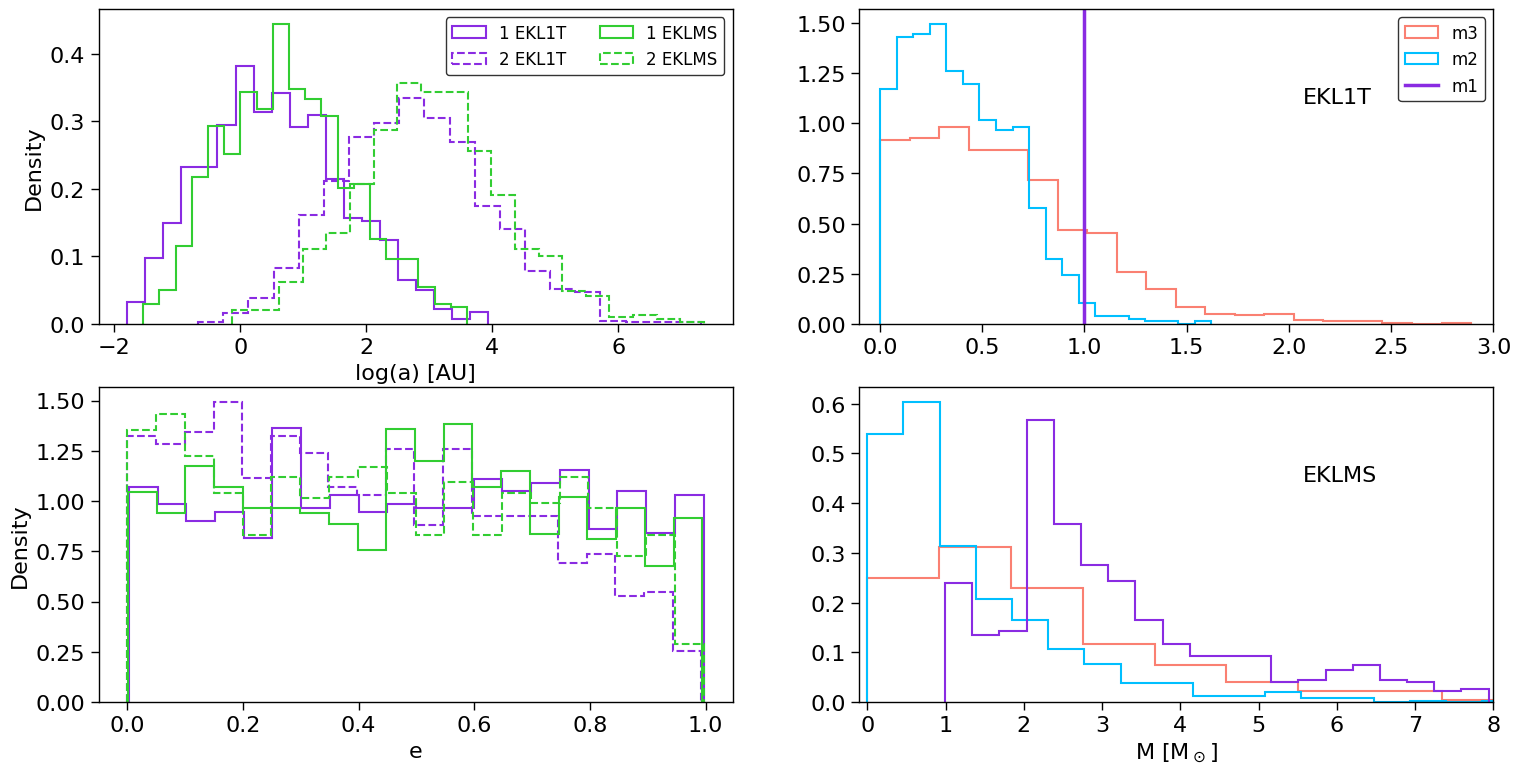

In [573]:
save_directory1='/Users/bijan1339/Desktop/Research/Figures/IC_dist_EKL1T.pdf'
save_directory2='/Users/bijan1339/Desktop/Research/Figures/IC_dist_EKLMS.pdf'

plot_initial_dists(initial7,saveFigure=False,save_directory=save_directory1)
#plot_initial_dists(initial9)#,saveFigure=True,save_directory=save_directory2)

In [465]:
def get_period(a,m1,m2,m3=0):
    '''returns period in days'''
    return np.sqrt(a**3 / (m1+m2+m3) )*365.25

def plot_all_periods(df_final,df_initial,close_df_final,close_df_initial,
                     saveFigure=False, save_directory='/Users/bijan1339/Desktop/Research/Figures/period_distribution_upd.pdf'):
    Roche1=Roche_limit(df_final['m1']/df_final['m2'])
    Roche2=Roche_limit(df_final['m2']/df_final['m1'])
    Roche1_criteria = df_final['R1'] > (df_final['a1']*(1-df_final['e1'])*Roche1)
    Roche2_criteria = df_final['R2'] > (df_final['a1']*(1-df_final['e1'])*Roche2)

    initial_periods = np.log10(df_initial['P_in'])
    final_periods = np.log10(df_final['P_in'])
    close_binaries = np.log10(close_df_initial['P_in'])
    roche_binaries = df_final[(df_final['sur'] == 0) | (df_final['sur2'] == 0)]
    roche_periods = np.log10(df_initial[df_initial['N'].isin(roche_binaries['N'])]['P_in'])

    fig, ((ax1,ax2)) = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))

    bins1 = np.linspace(np.min(initial_periods),np.max(initial_periods),16)
    bins2 = np.linspace(np.min(final_periods),np.max(final_periods),30)

    kwargs = {'bins': bins2,'histtype' :'step','linewidth':1.5,'density':False}

    n,b,p = ax1.hist(initial_periods,color='gray',label='Initial P$_{in}$',linestyle='--',**kwargs)
    ax2.hist(final_periods,label='Final P$_{in}$',color='black',**kwargs)
    ax1.hist(close_binaries,label='Close Binaries Initial P$_{in}$',color='blue',**kwargs)
    ax1.hist(roche_periods,label='Crossed Roche Limit (P$_{in}$)',color='magenta',**kwargs)

    ax1.axvline(np.log10(16),color='forestgreen',alpha=1.0,linewidth=1.8,label='16 days')
    ax2.set_xlabel('logP$_{in}$ [days]',fontsize=18,fontweight='bold')
    ax1.set_ylabel('N',fontsize=18,fontweight='bold'), ax2.set_ylabel('N',fontsize=18,fontweight='bold')
    ax1.legend(edgecolor="black", prop={'size': 12}), ax2.legend(edgecolor="black", prop={'size': 12}) #bbox_to_anchor=(0.6, 0.75)
    ax1.text(0,np.max(n)*0.9,'N= '+str(len(df_final)),fontsize=20) 

    ax1.set_xticks(np.arange(-1, 10, 1))
    ax2.set_xticks(np.arange(-1, 10, 1))

    if saveFigure:
        plt.savefig(save_directory)
        
    plt.show()

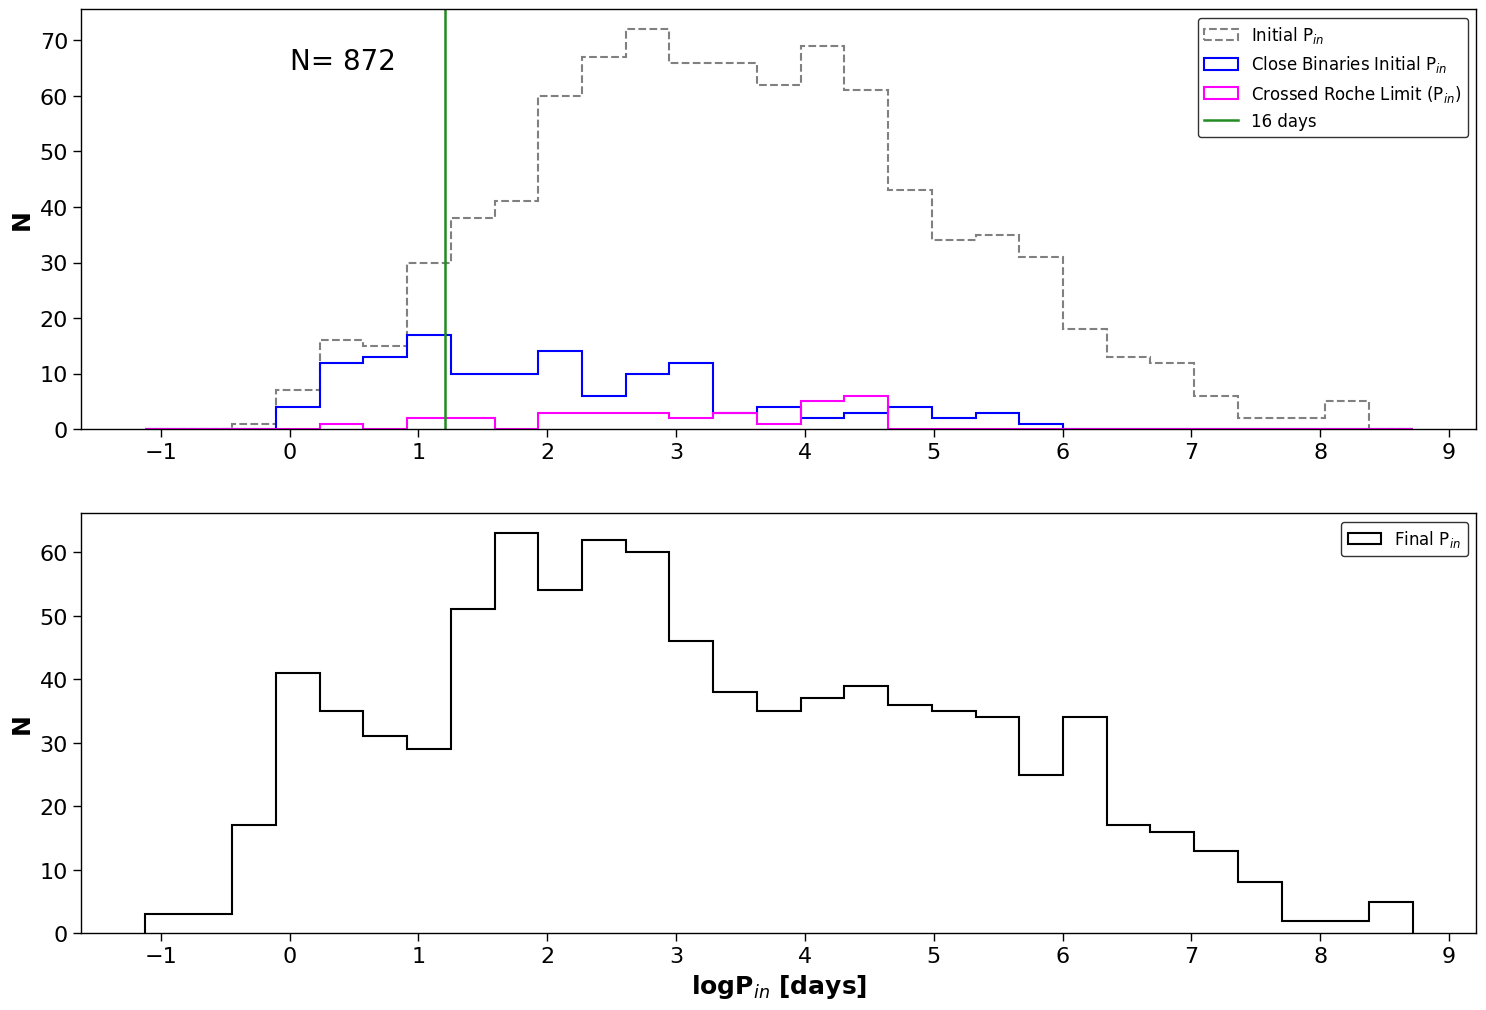

In [15]:
plot_all_periods(df_final7,df_initial7,close_df_final7,close_df_initial7,saveFigure=False)
#plot_all_periods(df_final8,df_initial8,close_df_final8,close_df_initial8,saveFigure=False)


In [30]:
def plot_binary_periods( param, axes_label, 
                        df_final,MSMS,WDMS,RGMS,WDWD,log = False, t14a=t14a, t14b_inner=t14b_inner,
                        saveFigure=False,save_directory='/Users/bijan1339/Desktop/Research/Figures/binary_period_dist.pdf'):
        
        fig = plt.figure(figsize=(16, 9))
 
        ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=1)
        ax2 = plt.subplot2grid(shape=(2, 2), loc=(0, 1), colspan=1)
        ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), colspan=2)
        
        df = pd.concat([MSMS,RGMS],axis=0)
        params_list = df_final[param]
        bins2, binsWD=[], []
        
        #make bins for histograms
        if log:
                dist_WDMS, dist_WDWD =  np.log10(WDMS[param]), np.log10(WDWD[param])
                dist_df, dist_MSMS    = np.log10(df[param]), np.log10(MSMS[param])
                
                minWD,maxWD = np.min( np.log10(WDMS[param])  ), np.max( np.log10(WDMS[param])  )
                minRG,maxRG = np.min( np.log10(RGMS[param])  ), np.max( np.log10(RGMS[param])  )
                params_list = np.log10(df_final[param])
        else:
                dist_WDMS, dist_WDWD = WDMS[param], WDWD[param]
                dist_df, dist_MSMS   = df[param], MSMS[param]

                minWD,maxWD = np.min(WDMS[param]) , np.max(WDMS[param]) 
                minRG,maxRG = np.min(RGMS[param]) , np.max(RGMS[param]) 

        
        
        if param == 'P_in':
                t14a_bin_trip = t14a[(t14a['Nc'] == '2') | (t14a['Nc'] == '3')]
                t14a_bin_trip = t14a_bin_trip[(t14a_bin_trip['Period'] != 0) & (t14a_bin_trip['M1'] != 0) & (t14a_bin_trip['M2'] != 0) ]

                y = np.log10(t14a_bin_trip[t14a_bin_trip['Period'] != 0 ]['Period']).replace(-np.inf, 0)
                yb = t14b_inner['logP']
                yc = np.log10(t17_inner['P'] *365.25)
                
                minWD,maxWD = np.min( np.log10(WDMS[param])  ), np.max( np.log10(WDMS[param])  )
                minRG,maxRG = np.min( np.log10(RGMS[param])  ), np.max( np.log10(RGMS[param])  )
                
                mint14a,maxt14a = -1.5, np.max( np.log10(t14a_bin_trip['Period'])  )
                binst14a = bins2 = np.linspace(np.min(yb),np.max(yb),24)
                
                ax2.hist(yb,histtype='step',linewidth=1.5,bins=bins2, density=True,label='T14b',color='orangered',cumulative=False, hatch='/')
                ax3.hist(yb,histtype='step',linewidth=2.0,bins=bins2, density=True,label='T14b',color='orangered',cumulative=False)
                
        elif param == 'm1/m2':
                t14a_bin_trip = t14a[(t14a['Nc'] == '2') | (t14a['Nc'] == '3')]
                t14a_bin_trip = t14a_bin_trip[(t14a_bin_trip['Period'] != 0) & (t14a_bin_trip['M1'] != 0) & (t14a_bin_trip['M2'] != 0) ]

                ya = t14a_bin_trip['M1'].astype(float) / t14a_bin_trip['M2'].astype(float)
                yb = t14b_inner['M1'] / t14b_inner['M2']
                
                mint14a,maxt14a = 0, np.max( t14b_inner['M1'] / t14b_inner['M2']  )
                
                binst14a = np.linspace(mint14a,maxt14a,14)
                binst14a = bins2 = np.linspace(0,maxt14a,24)#[0,1,2,3,4,5,6,7,10,15,20]
                binsWD = np.linspace(0,13,20)
                
                dist_WDMS, dist_WDWD =  dist_WDMS[dist_WDMS < maxt14a], dist_WDWD[dist_WDWD < maxt14a]
                dist_df, dist_MSMS   = dist_df[dist_df < maxt14a], dist_MSMS[dist_MSMS < maxt14a]
                
                ax2.hist(yb,histtype='step',linewidth=1.5,bins=bins2, density=True,label='T14b',color='orangered',cumulative=False, hatch='/')
                ax3.hist(ya,histtype='step',linewidth=1.5,bins=bins2, density=True,label='T14a',color='b',cumulative=False)

        binsRG = np.linspace(minRG,maxRG,14)
        
        if len(bins2) == 0: 
                bins2 = np.linspace(np.min(params_list),np.max(params_list),26)
        if len(binsWD) == 0:       
                binsWD = np.linspace(minWD,maxWD,20)
        
        kwargs = {'histtype' :'step','linewidth':2.5,'density':True}

        
        ax1.hist(dist_WDMS,bins=binsWD,label='WDMS',color='orangered',**kwargs)
        #ax1.hist(dist_WDWD,bins=binsWD,label='WDWD',color='b',**kwargs)

        ax2.hist(dist_df,bins=bins2,label='MSMS+RGMS',color='c',edgecolor='g',**kwargs)
        ax2.hist(dist_MSMS,bins=bins2,label='MSMS',color='c',edgecolor='b',**kwargs)
        ax2.text(0.1,0.9,f'N = {len(MSMS)}',fontsize = 14, transform = ax2.transAxes)

        ax3.hist(dist_MSMS,bins=bins2,label='MSMS P$_{in}$',facecolor='bisque',edgecolor='black',histtype='stepfilled',linewidth=2.5,density=True)
        ax3.hist(dist_df,bins=bins2,label='MSMS+RGMS',color='c',edgecolor='teal',**kwargs)
        
        ax1.set_ylabel('N',fontsize=18,fontweight='bold')
        ax3.set_ylabel('N',fontsize=18,fontweight='bold')

        ax1.set_xlabel(axes_label,fontsize=14,fontweight='bold')
        ax2.set_xlabel(axes_label,fontsize=14,fontweight='bold')
        ax3.set_xlabel(axes_label,fontsize=14,fontweight='bold')


        ax1.legend(edgecolor="black", prop={'size': 12})
        ax2.legend(edgecolor="black", prop={'size': 12})
        ax3.legend(edgecolor="black", prop={'size': 12})

        if saveFigure:
                plt.savefig(save_directory)
        plt.show()

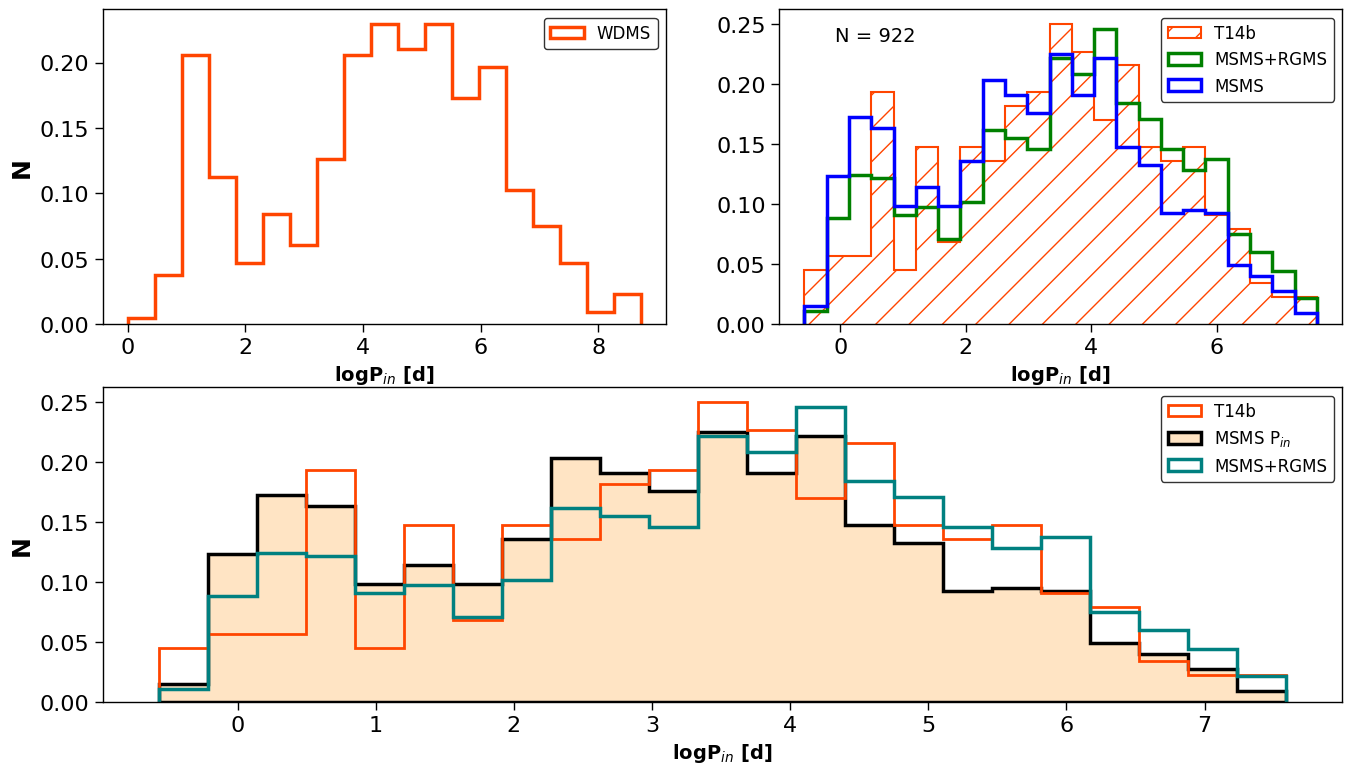

In [34]:
plot_binary_periods('P_in','logP$_{in}$ [d]',df_final7,MSMS7,WDMS7,RGMS7,WDWD7,log=True)
#plot_binary_periods('m1/m2','m1/m2', df_final7,MSMS7,WDMS7,RGMS7,WDWD7)

In [33]:
#plot_binary_periods('a1','log(a$_{in}$) [AU]',df_final7,MSMS7,WDMS7,RGMS7,WDWD7,log=True)
#plot_binary_periods('a1','log(a$_{in}$) [AU]',df_final8,MSMS8,WDMS8,RGMS8,WDWD8,log=True)


In [570]:
def epsilon(a1,a2,e2):
    return (   (a1/a2)* (  e2/(1-e2**2)  )  )

def plot_parameter_spaces(df_finals : tuple, WDMSs : tuple, WDWDs : tuple ,
                          saveFig = False, saveFigPath =  '/Users/bijan1339/Desktop/Research/Figures/parameter_space.pdf'):
    
    df_final1, df_final2 = df_finals
    WDMS1, WDMS2 = WDMSs
    WDWD1, WDWD2 = WDWDs

    fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))

    x1, y1 = np.log10(df_final7.a2), epsilon(df_final7.a1,df_final7.a2,df_final7.e2)
    x11, y11 = np.log10(WDMS1.a2), epsilon(WDMS1.a1,WDMS1.a2,WDMS1.e2)
    x111, y111 = np.log10(WDWD1.a2), epsilon(WDWD1.a1,WDWD1.a2,WDWD1.e2)

    x2, y2 = np.log10(df_final7.a1), x1
    x22, y22 = np.log10(WDMS1.a1), x11
    x222, y222 = np.log10(WDWD1.a1), x111

    u1, v1 = np.log10(df_final9.a2), epsilon(df_final9.a1,df_final9.a2,df_final9.e2)
    u11, v11 = np.log10(WDMS2.a2), epsilon(WDMS2.a1,WDMS2.a2,WDMS2.e2)
    u111, v111 = np.log10(WDWD2.a2), epsilon(WDWD2.a1,WDWD2.a2,WDWD2.e2)

    u2, v2 = np.log10(df_final9.a1), u1
    u22, v22 = np.log10(WDMS2.a1), u11
    u222, v222 = np.log10(WDWD2.a1), u111


    kwargs_scatter = {'s':13}
    c1, c2, c3 = 'gray', 'deepskyblue', 'r'

    ax1.scatter(x1,y1,color=c1, label='All',**kwargs_scatter)
    ax1.scatter(x11,y11,color=c2, label='WDMS',**kwargs_scatter)
    ax1.scatter(x111,y111,color=c3, label='WDWD',**kwargs_scatter)

    ax2.scatter(u1,v1,color=c1, label='All',**kwargs_scatter)
    ax2.scatter(u11,v11,color=c2, label='WDMS',**kwargs_scatter)
    ax2.scatter(u111,v111,color=c3, label='WDWD',**kwargs_scatter)

    ax3.scatter(x2,y2,color=c1, label='All',s = 25)
    ax3.scatter(x22,y22,color=c2, label='WDMS',**kwargs_scatter)
    ax3.scatter(x222,y222,color=c3, label='WDWD',**kwargs_scatter)

    ax4.scatter(u2,v2,color=c1, label='All',s = 25)
    ax4.scatter(u22,v22,color=c2, label='WDMS',**kwargs_scatter)
    ax4.scatter(u222,v222,color=c3, label='WDWD',**kwargs_scatter)


    ax1.set_title("EKL1T",fontsize=20), ax2.set_title("EKLMS",fontsize=20)
    ax1.set_xlabel("log(a2) [AU]"), ax1.set_ylabel("$\epsilon$",fontsize=20,fontweight="bold")
    ax2.set_xlabel("log(a2) [AU]")#, ax2.set_ylabel("$\epsilon$",fontsize=20,fontweight="bold")
    ax3.set_xlabel("log(a1) [AU]"), ax3.set_ylabel("log(a2) [AU]")
    ax4.set_xlabel("log(a1) [AU]")#, ax4.set_ylabel("log(a2) [AU]")

    ax1.set_ylim(-0.005, 0.1), ax2.set_ylim(-0.005, 0.1)
    ax3.set_ylim(top=8), ax4.set_ylim(top=8)

    ax2.legend(edgecolor='k',fontsize=13)
    
    if saveFig:
        fig.savefig(saveFigPath)

    plt.show()


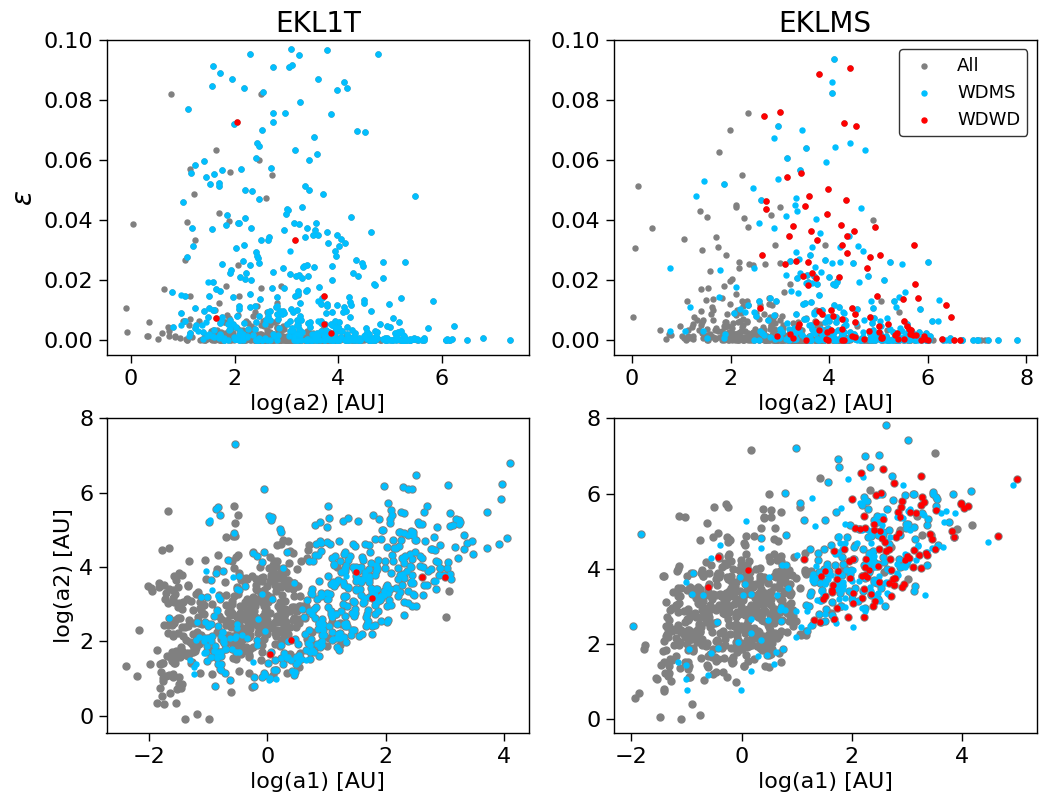

In [571]:
plot_parameter_spaces((df_final7,df_final9), (WDMS7,WDMS9), (WDWD7,WDWD9))

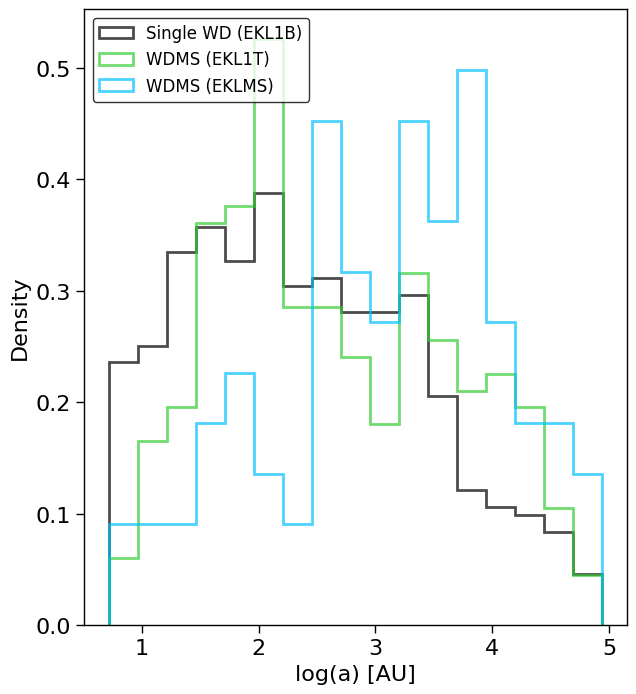

In [536]:

#MAKE INTO FUNCTION
plt.figure(figsize=(7,8))
df1 = df_final8.query("(type1 == 11. or type2 == 11.) and (a1 < 1e5) ")
df2 = WDMS7.query("a1 < 40 and a2 <= 1e5") #1, 40, 100
df3 = WDMS9.query("a1 < 40 and a2 <= 1e5")

x1 = np.log10(df1['a1'])
x2 = np.log10(df2['a2'])
x3 = np.log10(df3['a2'])

bins = np.linspace(np.min(np.concatenate((x1,x2,x3))),np.max(np.concatenate((x1,x2,x3))),18)
plt.hist(x1,bins=bins,density=True,label='Single WD (EKL1B)',histtype='step', 
          linewidth=2.,color='k',cumulative=False,alpha=0.7)
plt.hist(x2,bins=bins,density=True,label='WDMS (EKL1T)',histtype='step', 
          linewidth=2.,color='limegreen',cumulative=False,alpha=0.7)
plt.hist(x3,bins=bins,density=True,label='WDMS (EKLMS)',histtype='step', 
          linewidth=2.,color='deepskyblue',cumulative=False,alpha=0.7)

plt.xlabel('log(a) [AU]'), plt.ylabel('Density')
plt.legend(edgecolor='k',loc=2,fontsize=12)
plt.savefig('/Users/bijan1339/Desktop/Research/Figures/separation_distss.pdf')


In [111]:
#F&T (2007) Figure 10
#x1 = close_df_initial['P_in']#i_init_close
#y1 = close_df_initial['beta']#i_final_close
from matplotlib.pyplot import GridSpec
def plot_Pin_beta(close_df_final,saveFig=False,saveFigPath = '/Users/bijan1339/Desktop/Research/Figures/Figure5.pdf'): 
    x2 = close_df_final['P_in']#i_init_close
    y2 = close_df_final['beta']#i_final_close

    fig = plt.figure(figsize=(8,6))

    gs = GridSpec(4,4)

    ax = fig.add_subplot(gs[1:4,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])

    c1,c2 = 'navy','b'#colors
    #ax.scatter(x1,y1,label='Close Binaries',c=c1)
    ax.scatter(x2,y2,label='Close Binaries',c=c1)
    ax.set_ylim(top=180.)
    ax_marg_y.set_ylim(-3,180.)

    ax_marg_y.hist([y2],orientation="horizontal",histtype='step',color=[c1],density=False
                ,label=['All Runs','Close Binaries'])
    #ax_marg_y.legend(bbox_to_anchor=(0.7, 0.94),edgecolor="black")
    # Turn off tick labels on marginals
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    # Set labels on joint
    ax.set_xlabel('P$_{in}$ [days]',fontsize=16)
    ax.set_ylabel('beta [deg]',fontsize=16)

    # Set labels on marginals
    ax_marg_y.set_xlabel('N',fontsize=16)
    #ax.legend(loc=2)
    fig.subplots_adjust(wspace=0)
    plt.show()
    if saveFig: 
        fig.savefig(saveFigPath)

In [ ]:
plot_Pin_beta(close_df_final7)

In [400]:
from matplotlib.gridspec import GridSpec

def plot_i_change(df_initial,df_final,close_df_initial, close_df_final, 
                  saveFig=False, saveFigPath = '/Users/bijan1339/Desktop/Research/Figures/Figure5.pdf'):
    x1 = df_initial.sort_values('N')['i']
    y1 = df_final.sort_values('N')['i']

    x2 = close_df_initial['i']#i_init_close
    y2 = close_df_final['i']#i_final_close

    fig = plt.figure(figsize=(8,6))

    gs = GridSpec(4,4)

    ax = fig.add_subplot(gs[1:4,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])

    c1,c2 = 'gray','red'#colors
    ax.scatter(x1,y1,label='All Runs',c=c1,alpha=0.3)
    ax.scatter(x2,y2,label='Close Binaries',c=c2,edgecolor='k')
    ax_marg_y.hist([y1,y2],orientation="horizontal",histtype='step',color=[c1,c2],density=False
                ,label=['All Runs','Close Binaries'])
    #ax_marg_y.legend(bbox_to_anchor=(0.4, 0.938),edgecolor="k", fontsize=14)
    # Turn off tick labels on marginals
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    # Set labels on joint
    ax.set_xlabel('i$_{initial}$ [deg]',fontsize=16)
    ax.set_ylabel('i$_{final}$ [deg]',fontsize=16)

    # Set labels on marginals
    ax_marg_y.set_xlabel('N')
    ax.legend(loc=2,edgecolor='k',fontsize=14)
    fig.subplots_adjust(wspace=0)
    plt.show()
    
    if saveFig:
        fig.savefig(saveFigPath)

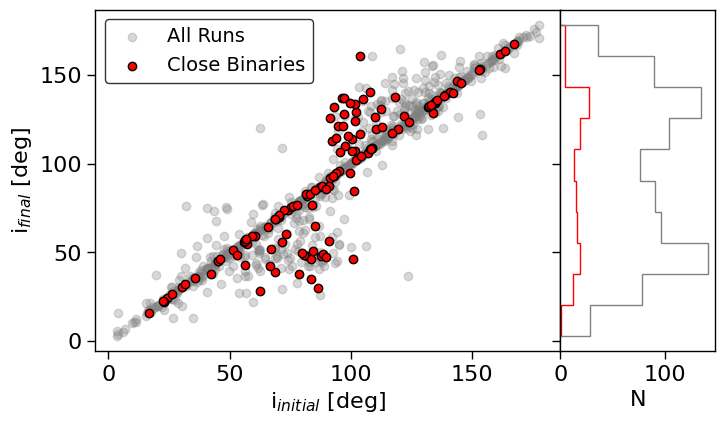

In [401]:
plot_i_change(df_initial7,df_final7,close_df_initial7, close_df_final7)

## Final Close Binaries that were not initially close is Larger than Naoz+2014
- ~11% up from 8%
- Likely due to Stellar Evolution

In [612]:
#PLOTTING FIGURE 3 (CLOSE BINARIES)
def plot_close_binaries(close_df_initial,close_df_final,
                        saveFig=False, saveFigPath = '/Users/bijan1339/Desktop/Research/Figures/close_binaries_new.pdf'):
    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9, 8))
    fig.subplots_adjust(hspace=0.4)
    close_periods_ini = np.sqrt(close_df_initial['a1']**3 / (close_df_initial['m1']+close_df_initial['m2']) )*365.25
    close_periods_final = np.sqrt(close_df_final['a1']**3 / (close_df_final['m1']+close_df_final['m2']) )*365.25

    periods_init_close, periods_final_close = np.log10(close_periods_ini),np.log10(close_periods_final)
    cmap = 'jet'
    scatter1 = ax1.scatter(np.log10(close_df_initial['P_in']),np.log10(close_df_final['P_in']),
                            c=close_df_final['e1'],cmap=cmap,vmin=0,vmax=0.5,s=13)
    ax1.set_xlabel('Initial log(P$_{in}$) [d]', fontsize = 16)
    ax1.set_ylabel('Final log(P$_{in}$) [d]', fontsize = 16)
    fig.colorbar(scatter1, ax=ax1, label="Final e$_1$",)

    #scatter2 = ax2.scatter(10**periods_final_close,e1_final_close,c=beta_close,cmap = cmap,s=13)
    scatter2 = ax2.scatter(close_df_final['P_in'], close_df_final['e1'], 
                            c=close_df_final['beta'], cmap = cmap,vmin=0,vmax=180, s=13)
    ax2.set_ylim(-0.1, top=1.)

    ax2.set_xlabel('Final P$_{in}$ [d]', fontsize = 16)
    ax2.set_ylabel('Final e$_1$', fontsize = 16)

    fig.colorbar(scatter2,ax=ax2, label="$\psi$ [deg]")

    plt.show()
    if saveFig:
        fig.savefig(saveFigPath)


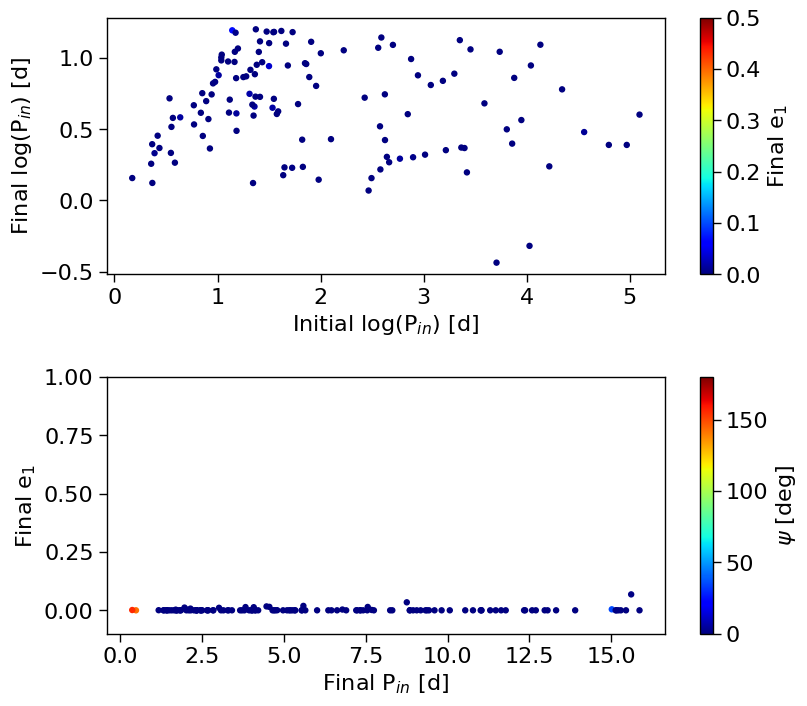

In [614]:
s='/Users/bijan1339/Desktop/Research/Figures/close_binaries_new.pdf'
plot_close_binaries(close_df_initial9,close_df_final9,saveFig=True,saveFigPath=s)

# Outer Binary Analyses

In [417]:
from matplotlib.gridspec import GridSpec


def period_psi_sorted(df_initial, df_final, MSMS, WDMS, RGMS, WDWD, t17_inner = t17_inner, t17_outer=t17_outer,
                      saveFig=False, saveFigPath = '/Users/bijan1339/Desktop/Research/Figures/period_psi_sorted.pdf'):
    x11 = np.log10(df_final['P_in'])
    y11 = df_final['beta']
    
    x2 = np.log10(df_final['P_in'])
    y2 = df_final['beta2']



    fig = plt.figure(figsize=(18,12))

    gs = GridSpec(12,10)

    ax = fig.add_subplot(gs[1:6,0:4])
    ax2 = fig.add_subplot(gs[7:12,0:4])
    ax3 = fig.add_subplot(gs[1:6,6:10])
    ax4 = fig.add_subplot(gs[7:12,6:10])

    ax_marg_y1 = fig.add_subplot(gs[1:6,4])
    ax_marg_y2 = fig.add_subplot(gs[7:12,4])

    #color_ax = fig.add_subplot(gs[6,0:3])

    cmap = 'jet'
    scatter1 = ax.scatter(x11,y11,color='tan',s=13,label='All',marker='o')
    #scatter1 = ax.scatter(np.log10(MSMS['P_in']),MSMS['beta'],color='tan',s=13,label='MSMS',marker='o')
    #scatter1 = ax.scatter(np.log10(RGMS['P_in']),RGMS['beta'],color='orangered',s=13,label='RGMS',marker='o')
    scatter1 = ax.scatter(np.log10(WDMS['P_in']),WDMS['beta'],color='navy',s=13,label='WDMS',marker='o')
    scatter1 = ax.scatter(np.log10(WDWD['P_in']),WDWD['beta'],color='r',s=13,label='WDWD',marker='o')

    ax2.scatter(x2,y2,color='tan',s=13,marker='o',label='All')
    #ax2.scatter(np.log10(MSMS['P_in']),MSMS['beta2'],label='MSMS',color='tan',s=13)
    #ax2.scatter(np.log10(RGMS['P_in']),RGMS['beta2'],label='RGMS',color='orangered',s=13)
    ax2.scatter(np.log10(WDMS['P_in']),WDMS['beta2'],label='WDMS',color='navy',s=13,alpha=0.6)
    ax2.scatter(np.log10(WDWD['P_in']),WDWD['beta2'],label='WDWD',color='r',s=13,alpha=0.6)


    #ax3.scatter(np.log10(MSMS['P_in']),MSMS['i'],color='tan',s=13)
    #ax3.scatter(np.log10(RGMS['P_in']),RGMS['i'],color='orangered',s=13)
    ax3.scatter(np.log10(df_final['P_in']),df_final['i'],color='tan',s=13)
    ax3.scatter(np.log10(WDMS['P_in']),WDMS['i'],color='navy',s=13)
    ax3.scatter(np.log10(WDWD['P_in']),WDWD['i'],color='r',s=13)

    ax3.scatter(np.log10(t17_inner['P']*365.25),t17_inner['Phi'],color='magenta',s=35,label='T17',marker='x')
    #ax4.scatter(np.log10(MSMS['P_out']),MSMS['i'],color='tan',s=13)
    #ax4.scatter(np.log10(RGMS['P_out']),RGMS['i'],color='orangered',s=13)
    ax4.scatter(np.log10(df_final['P_out']),df_final['i'],color='tan',s=13)
    ax4.scatter(np.log10(WDMS['P_out']),WDMS['i'],color='navy',s=13)
    ax4.scatter(np.log10(WDWD['P_out']),WDWD['i'],color='r',s=13)

    ax4.scatter(np.log10(t17_outer['P2']*365.25),t17_outer['Phi2'],color='magenta',s=35,label='T17',marker='x')


    #ax_marg_y1.hist(MSMS['beta'],orientation="horizontal",histtype='step',color='tan',density=True,linewidth=1.5,alpha=1.0)
    #ax_marg_y1.hist(RGMS['beta'],orientation="horizontal",histtype='step',color='orangered',density=True,linewidth=1.5,alpha=0.7)
    ax_marg_y1.hist(df_final['beta'],orientation="horizontal",histtype='step',color='tan',linewidth=2.5,density=True ,label='$\psi_{i}$ All')
    ax_marg_y1.hist(WDMS['beta'],orientation="horizontal",histtype='step',color='navy',density=True,linewidth=1.5,alpha=0.7)

    #ax_marg_y1.legend(bbox_to_anchor=(0.7, 0.94),edgecolor="black")

    ax_marg_y2.hist(y2,orientation="horizontal",histtype='step',color='tan',density=True ,label='$\psi_{f}$ All',linewidth=2.)
    ax_marg_y2.hist(WDMS['beta2'],orientation="horizontal",histtype='step',color='navy',density=True ,label='$\psi_{f}$ All',linewidth=2.)


    #ax_marg_y2.legend(bbox_to_anchor=(0.7, 0.94),edgecolor="black")

    # Turn off tick labels on marginals
    plt.setp(ax_marg_y1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y2.get_yticklabels(), visible=False)

    # Set labels on joint
    #ax.set_xlabel('log(P$_{in}$) [d]',fontsize=16)
    ax.set_ylabel('$\psi_{F,1}$  [$\circ$]',fontsize=16)
    ax2.set_xlabel('log(P$_{in}$) [d]',fontsize=16)
    ax2.set_ylabel('$\psi_{F,2}$  [$\circ$]',fontsize=16)
    #ax3.set_xlabel('log(P$_{in}$) [d]',fontsize=16)
    ax3.set_ylabel('i$_{tot}$  [$\circ$]',fontsize=16)
    ax4.set_xlabel('log(P$_{out}$) [d]',fontsize=16)
    ax4.set_ylabel('i$_{tot}$  [$\circ$]',fontsize=16)

    #ax.text(-1.,160,'Primary',fontsize=16)
    #ax2.text(-1.,160,'Secondary',fontsize=16)

    # Set labels on marginals
    ax_marg_y2.set_xlabel('N',fontsize=13)
    #ax_marg_y1.legend(),ax_marg_y2.legend()

    labels_y1 = [item for item in ax_marg_y1.get_xticks()]
    labels_y2 = [item for item in ax_marg_y2.get_xticks()]
    labels_y1[0] = ''
    labels_y2[0] = ''

    ax_marg_y1.set_xticklabels(labels_y1)
    ax_marg_y2.set_xticklabels(labels_y2)

    ax.legend(edgecolor='k',fontsize=13)
    #ax2.legend(edgecolor='k')
    ax3.legend(edgecolor='k',fontsize=13)
    #ax4.legend(edgecolor='k')

    fig.subplots_adjust(wspace=0)

    #COLORBAR SETTINGS
    # cbar_ax = fig.add_axes([0.13, 0.46, 0.30, 0.01]) #[left, bottom, width, height]
    # cb = fig.colorbar(scatter1, cax=cbar_ax, orientation="horizontal",ticks=[0, 0.2, 0.4, 0.6,0.8,1.])
    # scatter1.set_clim([0, 1])
    # cb.ax.text(1.02,0,'e$_1$', fontsize=16,fontweight='light')
    
    if saveFig:
        fig.savefig(saveFigPath)
    plt.show()

/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_7875/831187227.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_marg_y1.set_xticklabels(labels_y1)
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_7875/831187227.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_marg_y2.set_xticklabels(labels_y2)


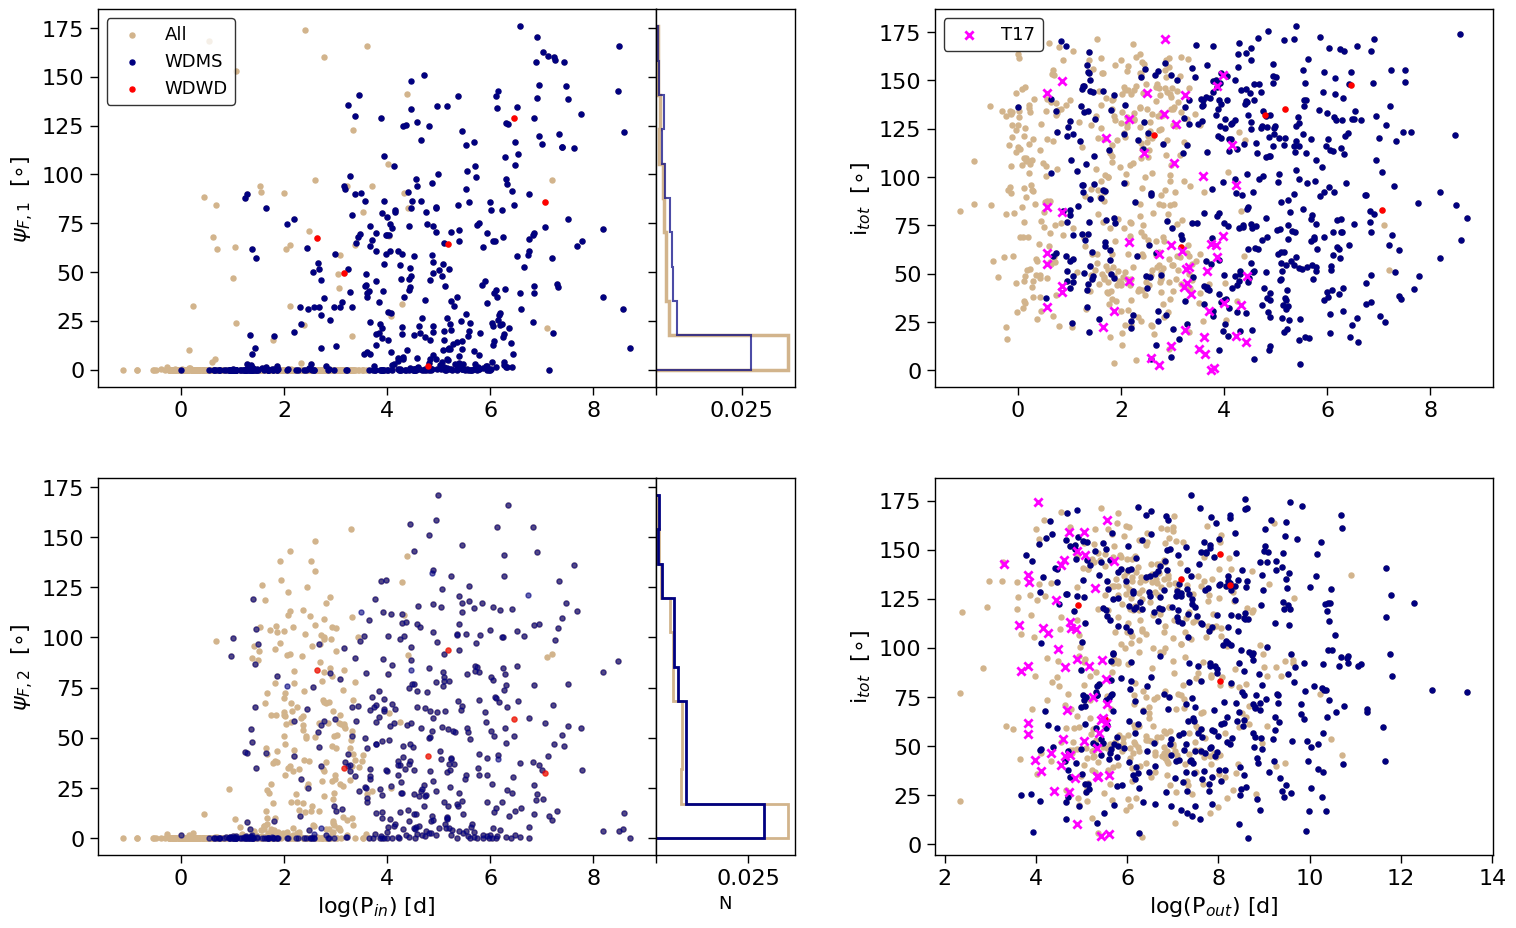

/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_7875/831187227.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_marg_y1.set_xticklabels(labels_y1)
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_7875/831187227.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_marg_y2.set_xticklabels(labels_y2)


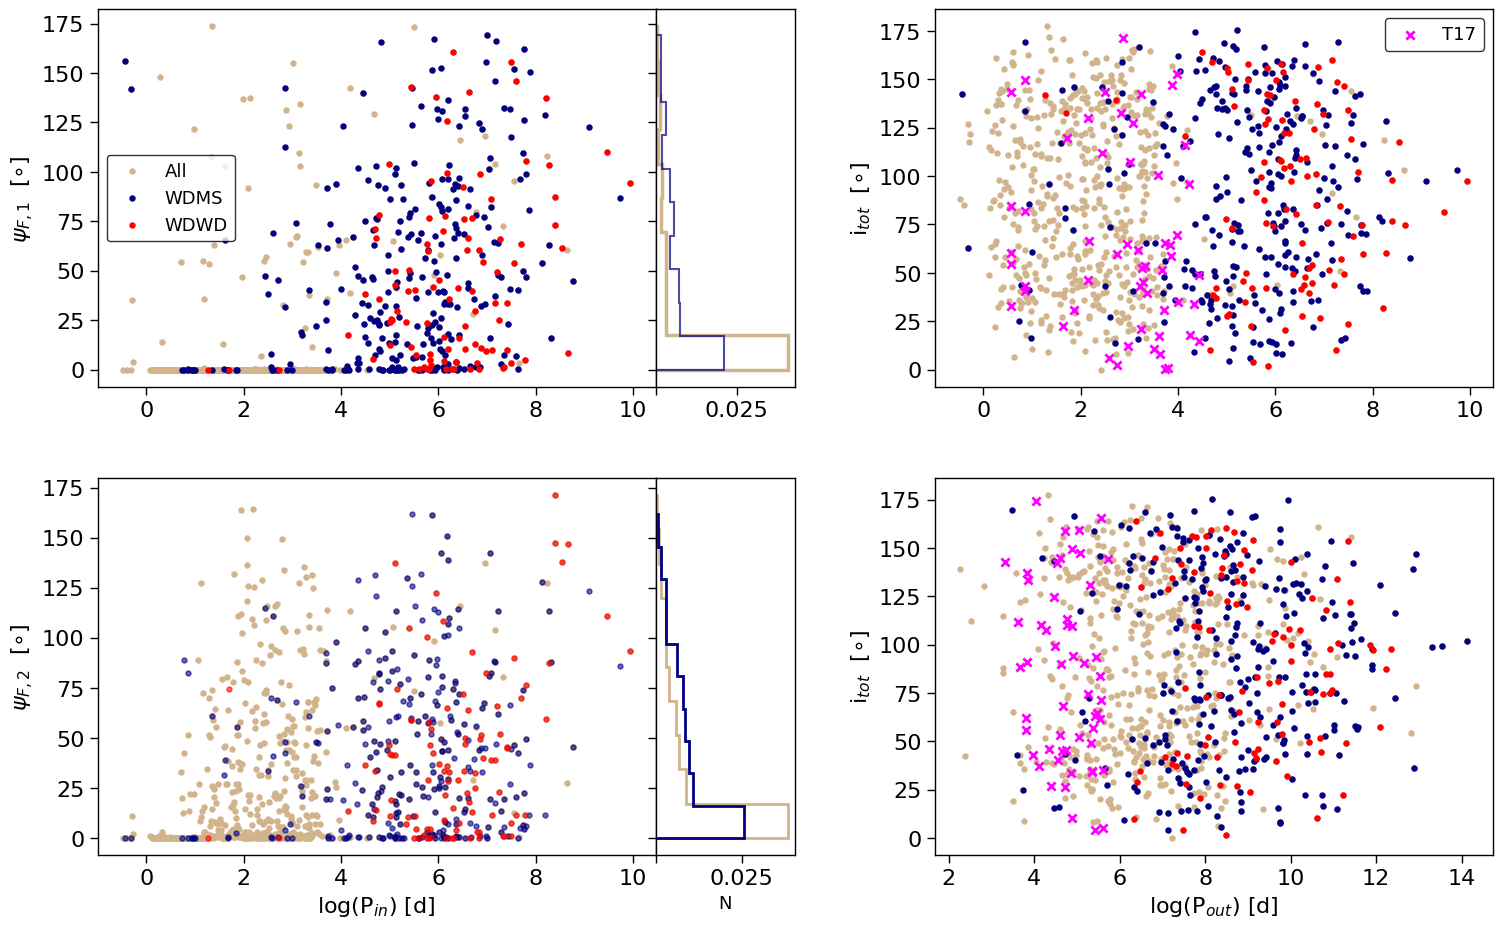

''

In [538]:
save_dir1 = '/Users/bijan1339/Desktop/Research/Figures/period_psi_1T.pdf'
save_dir2 = '/Users/bijan1339/Desktop/Research/Figures/period_psi_MS.pdf'


period_psi_sorted(df_initial7, df_final7, MSMS7, WDMS7, RGMS7,WDWD7,saveFig=True,saveFigPath=save_dir1)
period_psi_sorted(df_initial9, df_final9, MSMS9, WDMS9, RGMS9,WDWD9,saveFig=True,saveFigPath=save_dir2)

;

/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_86718/3339362429.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_marg_y1.set_xticklabels(labels_y1)
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_86718/3339362429.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_marg_y2.set_xticklabels(labels_y2)


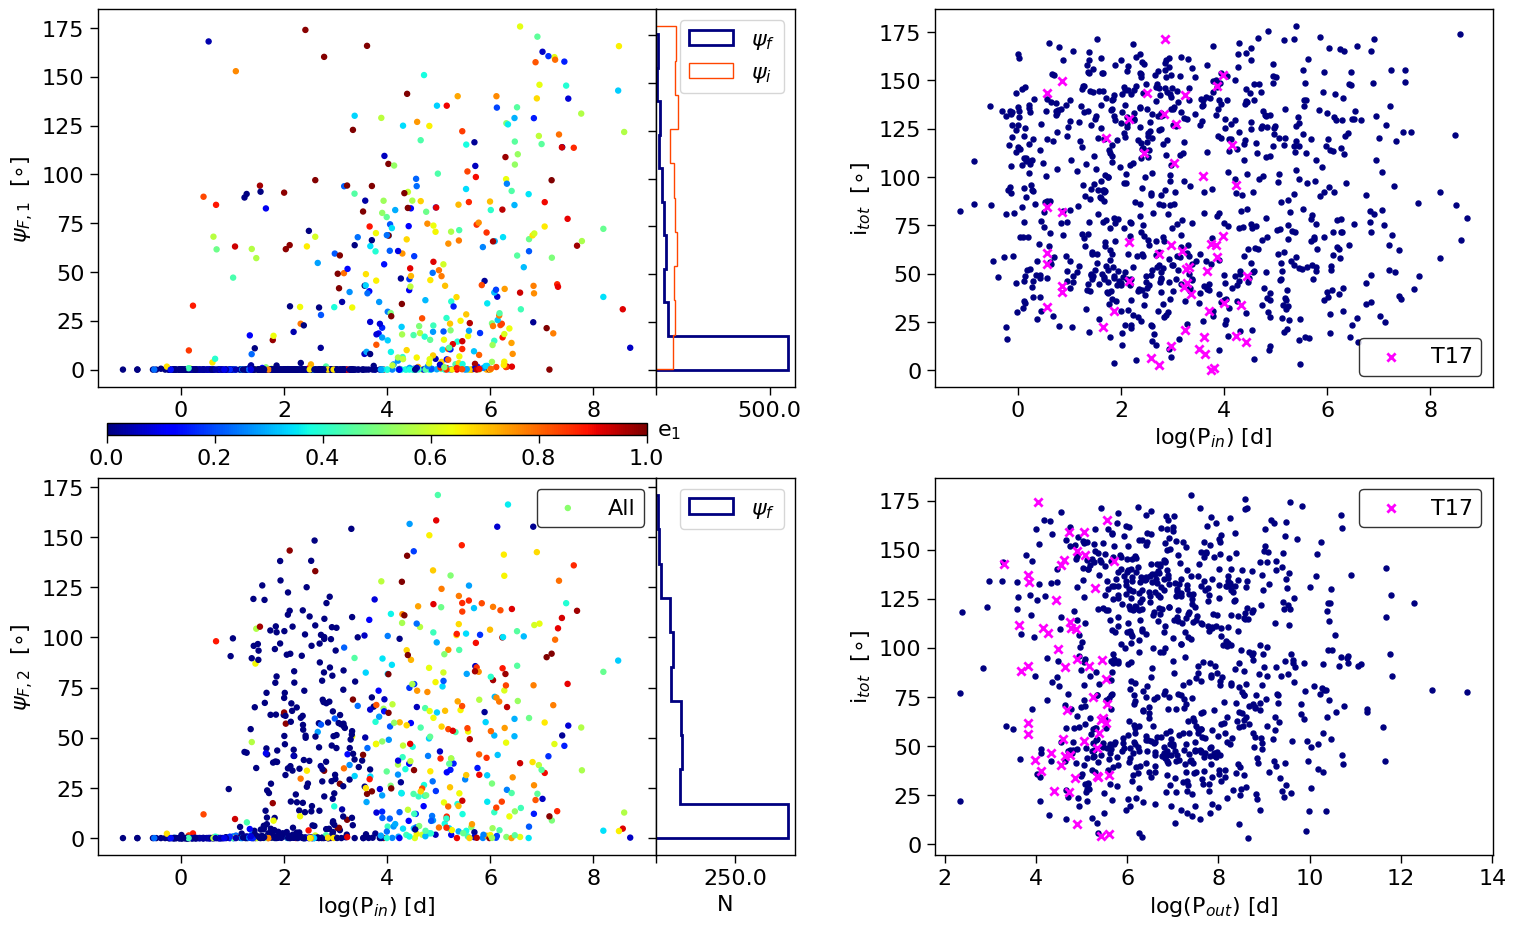

<IPython.core.display.Javascript object>

In [ ]:
# *** OLD ***
"""
x11 = np.log10(df_final['P_in'])
y11 = df_final['beta']
# x12 = np.log10(df_final['P_in'])
# y12 = df_final['beta']

x2 = np.log10(df_final['P_in'])
y2 = df_final['beta2']



fig = plt.figure(figsize=(18,12))

gs = GridSpec(12,10)

ax = fig.add_subplot(gs[1:6,0:4])
ax2 = fig.add_subplot(gs[7:12,0:4])
ax3 = fig.add_subplot(gs[1:6,6:10])
ax4 = fig.add_subplot(gs[7:12,6:10])

ax_marg_y1 = fig.add_subplot(gs[1:6,4])
ax_marg_y2 = fig.add_subplot(gs[7:12,4])

#color_ax = fig.add_subplot(gs[6,0:3])

cmap = 'jet'
scatter1 = ax.scatter(np.log10(df_final['P_in']),df_final['beta'],c=df_final['e1'],cmap=cmap,s=13,label='All')
ax2.scatter(np.log10(df_final['P_in']),df_final['beta2'],label='All',c=df_final['e1'],cmap=cmap,s=13)

ax3.scatter(np.log10(df_final['P_in']),df_final['i'],color='navy',s=13)
ax3.scatter(np.log10(t17_inner['P']*365.25),t17_inner['Phi'],color='magenta',s=35,label='T17',marker='x')
ax4.scatter(np.log10(df_final['P_out']),df_final['i'],color='navy',s=13)

ax4.scatter(np.log10(t17_outer['P2']*365.25),t17_outer['Phi2'],color='magenta',s=35,label='T17',marker='x')


ax_marg_y1.hist(df_final['beta'],orientation="horizontal",histtype='step',color='navy',density=False ,label='$\psi_{f}$',linewidth=2.)
ax_marg_y1.hist(df_initial['beta'],orientation="horizontal",histtype='step',color='orangered',density=False ,label='$\psi_{i}$')
#ax_marg_y1.legend(bbox_to_anchor=(0.7, 0.94),edgecolor="black")

ax_marg_y2.hist(y2,orientation="horizontal",histtype='step',color='navy',density=False ,label='$\psi_{f}$',linewidth=2.)
#ax_marg_y2.legend(bbox_to_anchor=(0.7, 0.94),edgecolor="black")

# Turn off tick labels on marginals
plt.setp(ax_marg_y1.get_yticklabels(), visible=False)
plt.setp(ax_marg_y2.get_yticklabels(), visible=False)

# Set labels on joint
#ax.set_xlabel('log(P$_{in}$) [d]',fontsize=16)
ax.set_ylabel('$\psi_{F,1}$  [$\circ$]',fontsize=16)
ax2.set_xlabel('log(P$_{in}$) [d]',fontsize=16)
ax2.set_ylabel('$\psi_{F,2}$  [$\circ$]',fontsize=16)
ax3.set_xlabel('log(P$_{in}$) [d]',fontsize=16)
ax3.set_ylabel('i$_{tot}$  [$\circ$]',fontsize=16)
ax4.set_xlabel('log(P$_{out}$) [d]',fontsize=16)
ax4.set_ylabel('i$_{tot}$  [$\circ$]',fontsize=16)

#ax.text(-1.,160,'Primary',fontsize=16)
#ax2.text(-1.,160,'Secondary',fontsize=16)

# Set labels on marginals
ax_marg_y2.set_xlabel('N',fontsize=16)
ax_marg_y1.legend(),ax_marg_y2.legend()

labels_y1 = [item for item in ax_marg_y1.get_xticks()]
labels_y2 = [item for item in ax_marg_y2.get_xticks()]
labels_y1[0] = ''
labels_y2[0] = ''

ax_marg_y1.set_xticklabels(labels_y1)
ax_marg_y2.set_xticklabels(labels_y2)

ax2.legend(edgecolor='k')
ax3.legend(edgecolor='k')
ax4.legend(edgecolor='k')

fig.subplots_adjust(wspace=0)

#COLORBAR SETTINGS
cbar_ax = fig.add_axes([0.13, 0.46, 0.30, 0.01]) #[left, bottom, width, height]
cb = fig.colorbar(scatter1, cax=cbar_ax, orientation="horizontal",ticks=[0, 0.2, 0.4, 0.6,0.8,1.])
scatter1.set_clim([0, 1])
cb.ax.text(1.02,0,'e$_1$', fontsize=16,fontweight='light')

#fig.savefig('/Users/bijan1339/Desktop/Research/Figures/period_psi.pdf')
plt.show()
"""

In [616]:
#OUTER ORBIT CONFIGURATION
def plot_outer_params(close_df_initial,close_df_final, t17_inner=t17_inner, t17_outer=t17_outer,
                      saveFig=False, saveFigPath = '/Users/bijan1339/Desktop/Research/Figures/outer_params.pdf'):
    
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
    cmap = 'jet'

    these_inner = t17_inner[t17_inner['a'] <=0.2]
    these_outer = t17_outer[t17_outer['WDS2'].isin(these_inner['WDS'])]

    scatter1 = ax1.scatter(np.log10(close_df_final['P_out']),close_df_final['e1'],
                        c=np.log10(close_df_final['t']).replace(-np.inf, 0),cmap=cmap,s=13)
    ax1.scatter(np.log10(these_outer['P2']*365.25),these_inner['e'],color='magenta',s=20,alpha=0.5,label='T17',marker='x')

    #ax1.scatter(np.log10(t17_outer['P']*365.25),t17_outer['e'],color='deepskyblue',s=13,label='T17')

    ax1.set_xlabel('log(P$_{out}$)',fontsize=16)
    ax1.set_ylabel('e$_1$',fontsize=16)
    fig.colorbar(scatter1,ax=ax1, label="log(t$_F$) [Gyr]")
    #ax1.set_ylim(top=1.)

    scatter2 = ax2.scatter(close_df_final['a1'],np.log10(close_df_final['a2']),c=close_df_initial['e2'],cmap=cmap,s=13)

    ax1.legend(edgecolor='k')
    ax2.set_xlabel('a$_1$ [AU]',fontsize=16)
    ax2.set_ylabel('log(a$_2$) [AU]',fontsize=16)
    fig.colorbar(scatter2,ax=ax2, label="Initial e2")
    #ax2.text(-0.5,150,'Secondary',fontsize=14)
    #ax2.plot(x,np.log10(35900*x/91-711/91))
    if saveFig:
        fig.savefig(saveFigPath)


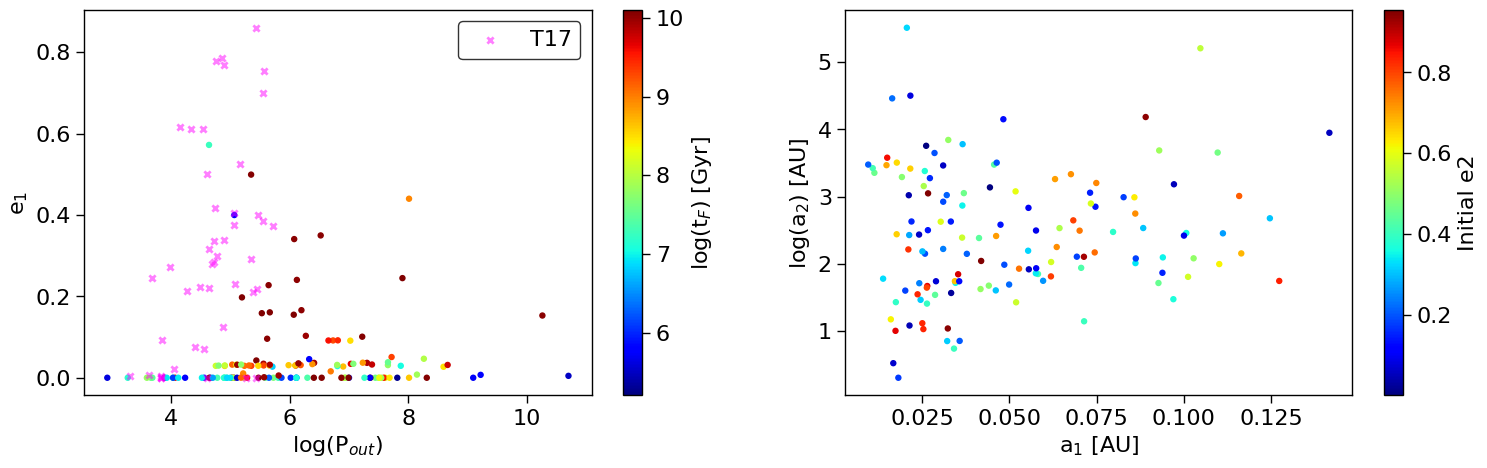

In [619]:
plot_outer_params(close_df_initial7,close_df_final7)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


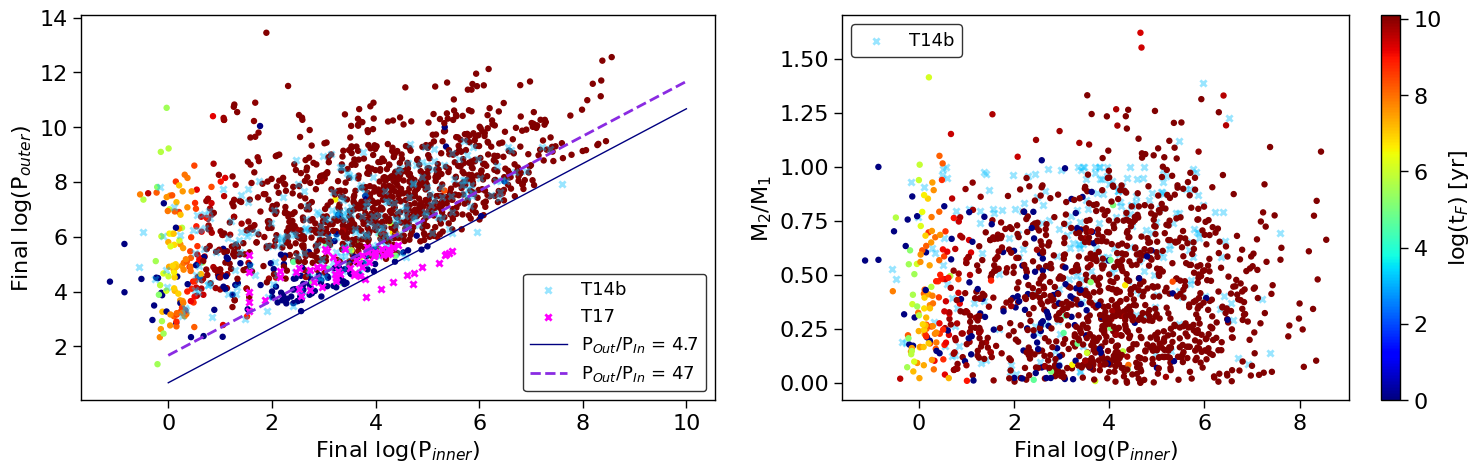

<IPython.core.display.Javascript object>

In [ ]:
#OUTER ORBIT CONFIGURATION
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
cmap = 'jet'
x = np.linspace(0,10,1000)
y = np.log10(4.7) +x
yy = np.log10(47) +x
multi = all_binary_types.query("binary_type == 'MSMS' or binary_type == 'RGMS'")
x1,y1 = np.log10(multi['P_in']), np.log10(multi['P_out'])
x2,y2 = np.log10(multi['P_in']), multi['m2']/multi['m1']

scatter1 = ax1.scatter(x1, y1,
                       c=np.log10(multi['t']).replace(-np.inf, 0),cmap=cmap,s=13)
ax1.scatter(t14b_inner['logP'], t14b_outer['logP'],color='deepskyblue',s=20,alpha=0.4,label='T14b',marker='x')
y17,y217 = np.log10(t17[t17['P_out']!=0.]['P1']*365.25),np.log10(t17[t17['P_out']!=0.]['P_out']*365.25)
ax1.scatter(y17, y217,color='magenta',s=20,alpha=1.,label='T17',marker='x')


ax1.set_xlabel('Final log(P$_{inner}$)',fontsize=16), ax1.set_ylabel('Final log(P$_{outer}$)',fontsize=16)

# ax2.scatter(np.log10(t14a['Period']), t14a['M2'].astype(float)/t14a['M1'].astype(float),
#             color='gray', alpha=0.3, s=15,label='T14a')
ax2.scatter(t14b_inner['logP'], t14b_inner['M2']/t14b_inner['M1'],
            color='deepskyblue',s=20,alpha=0.4,label='T14b',marker='x')
scatter2 = ax2.scatter(x2, y2,
                       c=np.log10(multi['t']).replace(-np.inf, 0),cmap=cmap,s=13)
ax2.set_xlabel('Final log(P$_{inner}$)',fontsize=16), ax2.set_ylabel('M$_2$/M$_1$',fontsize=16)
fig.colorbar(scatter2,ax=ax2, label="log(t$_F$) [yr]")
ax1.plot(x,y,color='navy',linewidth=1.,label = 'P$_{Out}$/P$_{In}$ = 4.7')
ax1.plot(x,yy,'--',color='blueviolet',label = 'P$_{Out}$/P$_{In}$ = 47')

ax1.legend(loc=4,frameon=1,edgecolor='k',prop={'size': 13}), ax2.legend(frameon=1,edgecolor='k',prop={'size': 13},loc=2)

#plt.savefig('/Users/bijan1339/Desktop/Research/Figures/Period_Ratios.pdf')
plt.show()


In [523]:
#OUTER ORBIT CONFIGURATION
def plot_periods_ratios(all_binary_types, MSMS, WDMS, RGMS, t17=t17, t14b_inner=t14b_inner, t14b_outer=t14b_outer,
                        saveFig=False, saveFigPath = '/Users/bijan1339/Desktop/Research/Figures/Period_Ratios_col.pdf'):
    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 11)) #18,5
    cmap = 'jet'
    x = np.linspace(0,10,1000)
    y = np.log10(4.7) + x
    yy = np.log10(47) + x
    
    multi = all_binary_types.query("binary_type == 'MSMS' or binary_type == 'RGMS'")
    x1,y1 = np.log10(MSMS['P_in']), np.log10(MSMS['P_out'])
    x2,y2 = np.log10(MSMS['P_in']), MSMS['m2']/MSMS['m1']
    x3,y3 = np.log10(WDMS['P_in']), np.log10(WDMS['P_out'])

    x11,y11 = np.log10(RGMS['P_in']), np.log10(RGMS['P_out'])
    x22,y22 = np.log10(RGMS['P_in']), RGMS['m2']/RGMS['m1']
    x33,y33 = np.log10(WDMS['P_in']), WDMS['m2']/WDMS['m1']

    y17,y217 = np.log10(t17[t17['P_out']!=0.]['P1']*365.25),np.log10(t17[t17['P_out']!=0.]['P_out']*365.25)


    ax1.scatter(x1, y1,color='tan',s=13,label='MSMS')
    ax1.scatter(x11, y11,color='orangered',s=13,label='RGMS')
    ax1.scatter(x3, y3,color='navy',s=13,label='WDMS')

    ax1.scatter(t14b_inner['logP'], t14b_outer['logP'],color='springgreen',s=20,alpha=0.8,label='T14b',marker='v')
    ax1.scatter(y17, y217,color='deepskyblue',s=20,alpha=0.6,label='T17',marker='^')


    ax1.set_xlabel('log(P$_{inner}$)',fontsize=16), ax1.set_ylabel('Final log(P$_{outer}$)',fontsize=16)

    # ax2.scatter(np.log10(t14a['Period']), t14a['M2'].astype(float)/t14a['M1'].astype(float),
    #             color='gray', alpha=0.3, s=15,label='T14a')
    ax2.scatter(x2, y2,color='tan',s=13,label='MSMS')
    ax2.scatter(x22, y22,color='orangered',s=13,label='RGMS')
    ax2.scatter(x33, y33,color='navy',s=13,label='WDMS')

    ax2.scatter(t14b_inner['logP'], t14b_inner['M2']/t14b_inner['M1'],
                color='springgreen',s=20,alpha=0.8,label='T14b',marker='v')

    ax2.set_xlabel('log(P$_{inner}$)',fontsize=16), ax2.set_ylabel('M$_2$/M$_1$',fontsize=16)
    ax1.plot(x,y,color='k',linewidth = 2)
    ax1.plot(x,yy,'--',color='blueviolet',linewidth = 2)

    ax1.legend(ncol=2,loc=4,frameon=1,edgecolor='k',prop={'size': 11})#, ax2.legend(frameon=1,edgecolor='k',prop={'size': 12},loc=2)
    ax1.text(0.8,0.5,'P$_{Out}$/P$_{In}$ = 4.7',transform = ax1.transAxes,color='k',fontsize=13)
    ax1.text(0.8,0.55,'P$_{Out}$/P$_{In}$ = 47',transform = ax1.transAxes,color='blueviolet',fontsize=13)
    
    if saveFig:
        fig.savefig('/Users/bijan1339/Desktop/Research/Figures/Period_Ratios_col.pdf')
        
    plt.show()

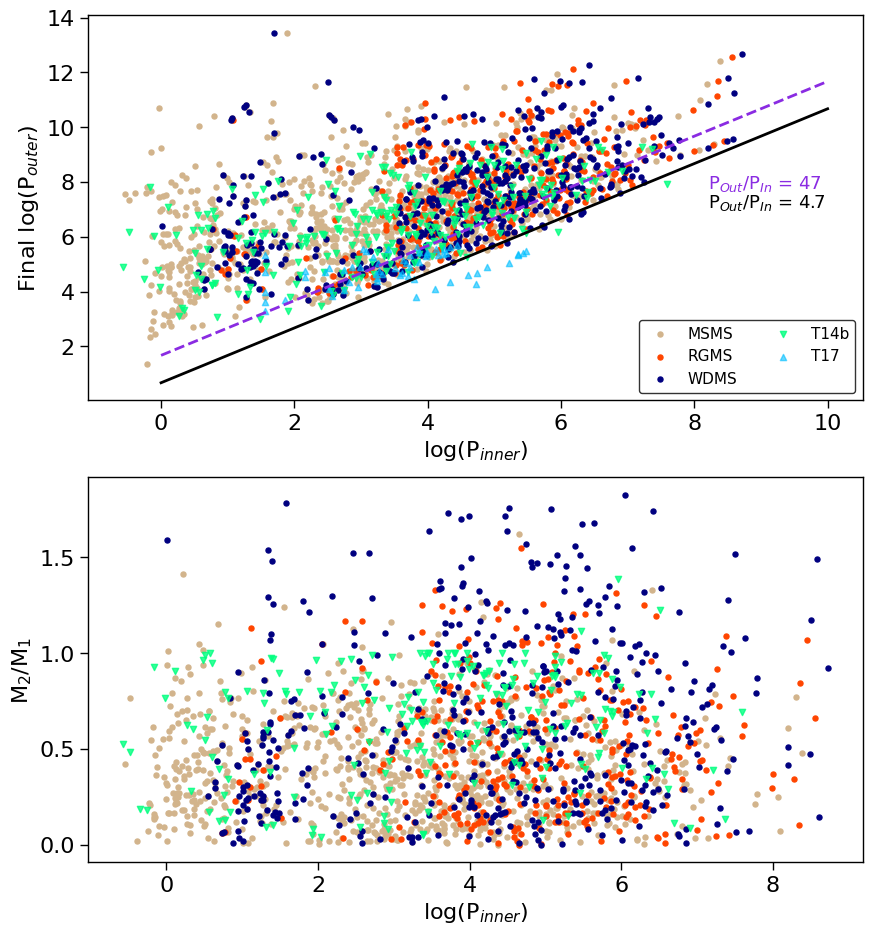

In [524]:
plot_periods_ratios(all_binary_types7, MSMS7, WDMS7, RGMS7,saveFig=True)


In [621]:
WDWD9.sort_values('a1')

# WRITE FUNCTION TO GET ALL OF CERTAIN PARAMETERS FROM FILE, DURING ALL STAGES, GIVEN THE SPECIFIC FILENAME
#CAN PLOT HOW THE PARAMETERS CHANGED OVER TIME

#write function, that for a given last_line, can go back into the relevant output file and return row that contains that substring
#for example, given a WDWD line, it will return it at either the MSMS stage, or WDMS, or RGMS
# can use this to almost track the evolution of the parameters

,N,sur,sur2,t,e1,e2,g1,g2,a1,i1,i2,i,spin1h,spintot,beta,vp,spin1e,spin1q,spin2e,spin2q,spin2h,htot,m1,R1,m2,R2,a2,m3,Roche1,R1_pow,type1,type2,type3,beta2,gamma,gamma2,flag,binary_type,P_in,P_out,m1/m2
7,9605,7.0,2.0,3.560148e+08,0.103015,0.653435,1.209841,3.094101,0.247688,140.95840,0.826104,141.78450,1.242209e+02,1.242209e+02,0.000000,0.0000,3.737948e-08,1.338913e-08,5.915323e-08,2.062753e-08,1.334655e+02,7.662510,3.077000,0.023103,2.991900,0.019412,3.378503e+03,0.7961,0.048290,0.018251,11.0,11.0,11.0,0.000000,0.000000,0.00000,END,WDWD,1.827653e+01,2.737514e+07,1.028443
1033,9493,1.0,2.0,1.275000e+09,0.329528,0.541873,-0.058856,-1.010214,0.372222,132.68320,0.147653,132.83090,7.708396e+01,7.708396e+01,0.000000,132.8309,0.000000e+00,0.000000e+00,-1.648396e-01,3.622756e-02,4.751543e-02,5.935559,2.042670,0.049894,0.646900,0.000057,2.018348e+04,0.7664,0.091143,0.031029,11.0,11.0,11.0,74.276310,0.000000,167.60490,WD,WDWD,5.057692e+01,5.633773e+08,3.157629
282,9978,1.0,2.0,1.250019e+10,0.129529,0.342161,-1.845851,1.347967,1.330567,139.10920,0.246556,139.35580,2.102521e+02,2.102521e+02,0.014525,0.0000,-3.646613e-02,3.887280e-02,-2.551743e-05,-8.527091e-06,1.510259e+00,7.527433,0.548799,0.013414,0.548300,0.012685,9.287409e+03,0.6685,0.028163,0.010645,11.0,11.0,11.0,0.001021,133.170300,161.52200,END,WDWD,5.352079e+02,2.460289e+08,1.000909
1938,9620,1.0,2.0,1.250000e+10,0.484428,0.020457,2.887445,-2.527530,13.734880,120.34900,0.510376,120.85940,1.332299e-01,1.396649e-01,17.460310,120.8602,4.190519e-02,-2.210502e-04,1.176795e-06,4.113123e-07,5.254681e-06,27.506370,1.129298,0.018481,0.693900,0.008662,1.868238e+04,1.3018,0.036134,0.013393,11.0,11.0,13.0,13.345960,0.302233,19.26549,END,WDWD,1.376926e+04,5.276108e+08,1.627465
409,9211,1.0,2.0,1.250000e+10,0.019929,0.467757,1.889869,2.262166,20.618120,160.80190,3.171817,163.97370,2.306870e+05,2.927789e+05,38.008240,162.0873,-1.787357e+05,-2.359153e+04,-2.802864e+02,2.177092e+02,4.820557e+02,31.421010,0.636900,0.000057,0.576500,0.000061,4.340018e+02,0.6979,0.000118,0.000045,11.0,11.0,11.0,36.361720,172.480900,142.16210,END,WDWD,3.104287e+04,2.388708e+06,1.104770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731,9839,1.0,2.0,1.250003e+10,0.472937,0.758517,1.687620,-0.291400,9592.422000,92.28151,5.498201,97.77971,4.747420e-07,9.752463e-06,87.209780,0.0000,8.198902e-06,-5.259578e-06,-5.665966e-07,-6.201628e-07,-5.463833e-06,746.242000,1.121895,0.000031,0.772299,0.000049,5.388057e+05,1.0780,0.000061,0.000023,11.0,11.0,11.0,171.259700,32.680080,132.41560,END,WDWD,2.493277e+08,8.379150e+10,1.452670
297,9206,1.0,2.0,1.250003e+10,0.573447,0.138077,-0.380792,-1.500143,10989.740000,112.29770,5.472533,117.77020,2.512914e-06,5.227821e-06,61.270120,0.0000,4.430010e-06,-1.179146e-06,1.065779e-09,-3.707114e-06,-4.069078e-06,656.428700,0.712199,0.000053,0.767600,0.000050,4.136699e+05,0.5685,0.000112,0.000042,11.0,11.0,11.0,137.665100,14.904970,89.98353,END,WDWD,3.459154e+08,6.790072e+10,0.927827
972,9243,1.0,2.0,1.250003e+10,0.884858,0.118951,2.376254,2.434778,12816.990000,72.26463,2.629668,74.89429,5.123761e-06,5.182298e-06,8.619816,0.0000,-4.148952e-07,-6.566114e-07,5.525006e-07,-2.542206e-06,-3.982525e-06,374.682400,0.701400,0.000053,0.577000,0.000061,4.555880e+05,0.6323,0.000109,0.000041,11.0,11.0,11.0,146.845800,122.287700,77.73852,END,WDWD,4.687442e+08,8.125543e+10,1.215598
1259,9734,3.0,3.0,1.250002e+10,0.806574,0.481591,2.324384,1.744595,44893.780000,61.89635,19.308010,81.20436,-2.854705e+03,8.270178e+03,110.192800,0.0000,1.975006e+03,7.506387e+03,1.183853e-06,4.247943e-06,-1.664996e-06,948.812100,0.899400,0.000043,0.554200,0.000062,7.315164e+04,0.5663,0.000084,0.000031,11.0,11.0,11.0,110.684800,75.259000,74.42746,END,WDWD,2.881689e+09,5.084654e+09,1.622880


# Comparing to Observations

In [305]:
def plot_periods_compare(MSMS, RGMS, WDMS, t17_4obs=t17_4obs, t17_concat=t17_concat,
                        saveFig=False, saveFigPath = '/Users/bijan1339/Desktop/Research/Figures/T17_compare.pdf'):

        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

        these = pd.concat([MSMS,RGMS])#[df_final['P_out'] <= 80*365.25]
        y17,y217 = np.log10(t17_concat['P2'].reset_index(drop=True)/t17_concat['P'].reset_index(drop=True)),t17_concat['e2']

        ax1.scatter(np.log10(MSMS['P_out']/MSMS['P_in']),MSMS['e2'],color='tan',s=15 )
        ax1.scatter(np.log10(RGMS['P_out']/RGMS['P_in']),RGMS['e2'],color='orangered',s=15 )
        ax1.scatter(np.log10(WDMS['P_out']/WDMS['P_in']),WDMS['e2'],color='navy',s=15 )

        ax2.scatter(np.log10(MSMS['P_out']),MSMS['i'],color='tan',s=15 )
        ax2.scatter(np.log10(RGMS['P_out']),RGMS['i'],color='orangered',s=15 )
        ax2.scatter(np.log10(WDMS['P_out']),WDMS['i'],color='navy',s=15 )

        #Observations
        ax1.scatter(y17,y217,color='limegreen',marker='x',label='Observed T17',s=80)
        #ax1.errorbar(np.log10(t17_4obs['Po/Pi']), t17_4obs['eout'], xerr=t17_4obs['e_Po/Pi'],fmt="+",color='deepskyblue')
        ax1.scatter(np.log10(t17_4obs['Po/Pi']),t17_4obs['eout'],color='magenta',marker='*',label='Observed T17',s=150,zorder=3, facecolors='none')
        ax2.scatter(np.log10(t17_4obs['Pout']*365.25),t17_4obs['Phi'],color='magenta',marker='*',label='Observed T17',s=150, facecolors='none')
        ax2.scatter(np.log10(t17_concat['P2']*365.25),t17_concat['Phi2'],color='limegreen',marker='x',label='Observed T17',s=80, facecolors='none')

        ax1.set_xlabel('log(P$_{OUT}$/P$_{IN}$)',fontsize=16)
        ax1.set_ylabel('e$_2$',fontsize=16)

        ax2.set_xlabel('log(P$_{OUT}$)',fontsize=16)
        ax2.set_ylabel('$\Phi$',fontsize=16)

        ax1.legend(edgecolor='k',frameon=1,fontsize=12)
        ax1.set_xlim(-1,4), ax2.set_xlim(3,7)
        #ax1.set_ylim(), ax2.set_ylim()

        if saveFig:
            fig.savefig('/Users/bijan1339/Desktop/Research/Figures/T17_compare.pdf')
            
        plt.show()

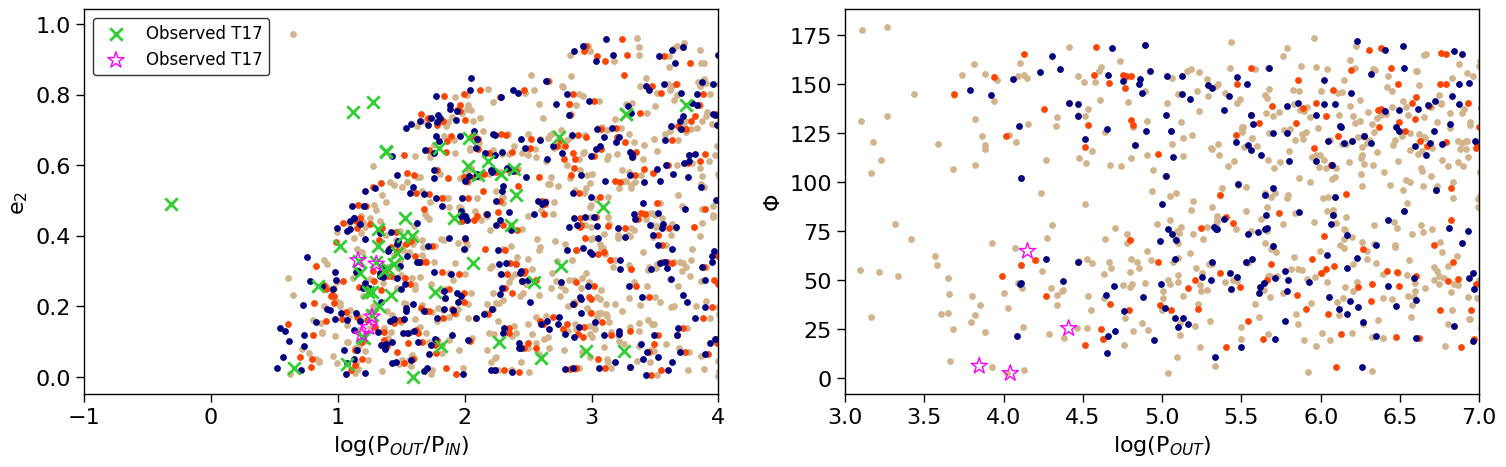

In [306]:
plot_periods_compare(MSMS7, RGMS7, WDMS7)


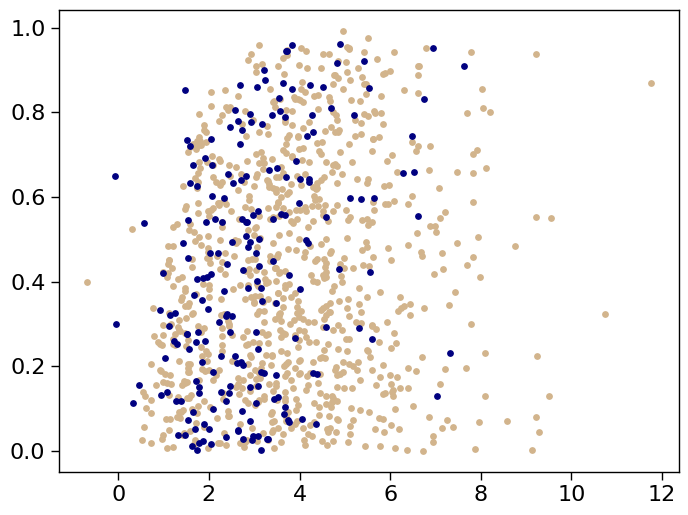

In [312]:
plt.scatter(np.log10(df_final7['P_out']/df_final7['P_in']),df_final7['e2'],color='tan',s=15 )
plt.scatter(np.log10(WDMS9['P_out']/WDMS9['P_in']),WDMS9['e2'],color='navy',s=15 )

#plt.xlim(right=4)

In [606]:
def plot_all_vs_other(df_final,close_df_final,merged_df_final, 
                      saveFig=False, saveFigPath = '/Users/bijan1339/Desktop/Research/Figures/all_vs_other.pdf'):
    
    fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18, 9))
    
    x1 = df_final['m3']/(df_final['m1']+df_final['m2'])
    x2 = close_df_final['m3']/(close_df_final['m1']+close_df_final['m2'])
    x3 = merged_df_final['m3']/(merged_df_final['m1']+merged_df_final['m2'])
    
    y1 = np.log10(df_final['P_out'])
    y2 = np.log10(close_df_final['P_out'])
    y3 = np.log10(merged_df_final['P_out'])
    
    z1 = df_final['e2']
    z2 = close_df_final['e2']
    z3 = merged_df_final['e2']
    
    w1 = df_final['e1']
    w2 = close_df_final['e1']
    w3 = merged_df_final['e1']
    
    kwargs_hist = {'histtype' :'step','linewidth':1.5,'density':True}
    bins_m = np.linspace(  np.min(np.concatenate((x1,x2,x3))),np.max(np.concatenate((x1,x2,x3))), 18   )
    bins_P = np.linspace(  np.nanmin(np.concatenate((y1,y2,y3))),np.nanmax(np.concatenate((y1,y2,y3))), 18   )
    bins_e = np.linspace(  np.nanmin(np.concatenate((z1,z2,z3))),np.nanmax(np.concatenate((z1,z2,z3))), 18   )

    ax1.hist(x1,color='limegreen',label='All',bins=bins_m, **kwargs_hist)
    ax1.hist(x2,color='navy',label='Close',bins=bins_m, **kwargs_hist)
    ax1.hist(x3,color='r',label='Roche',bins=bins_m, **kwargs_hist)

    ax1.set_xlabel('m$_3$/(m$_1$+m$_2$)',fontsize=16)
    ax1.set_ylabel('Density',fontsize=16), ax3.set_ylabel('Density',fontsize=16)

    ax2.hist(y1, color='limegreen',label='All',bins=bins_P,**kwargs_hist)
    ax2.hist(y2,color='navy',label='Close',bins=bins_P,**kwargs_hist)
    ax2.hist(y3,color='r',label='Roche',bins=bins_P,**kwargs_hist)

    ax3.hist(z1, color='limegreen',label='All',bins=bins_e,**kwargs_hist)
    ax3.hist(z2,color='navy',label='Close',bins=bins_e,**kwargs_hist)
    ax3.hist(z3,color='r',label='Roche',bins=bins_e,**kwargs_hist)
    
    ax4.hist(w1, color='limegreen',label='All',bins=bins_e,**kwargs_hist)
    ax4.hist(w2,color='navy',label='Close',bins=bins_e,**kwargs_hist)
    ax4.hist(w3,color='r',label='Roche',bins=bins_e,**kwargs_hist)

    ax2.set_xlabel('log(P$_{Out}$)',fontsize=16)
    ax3.set_xlabel('e$_2$',fontsize=16)
    #ax2.set_ylabel('Density',fontsize=16)

    ax2.legend()
    plt.show()
    
    if saveFig:
        fig.savefig(saveFigPath)
        

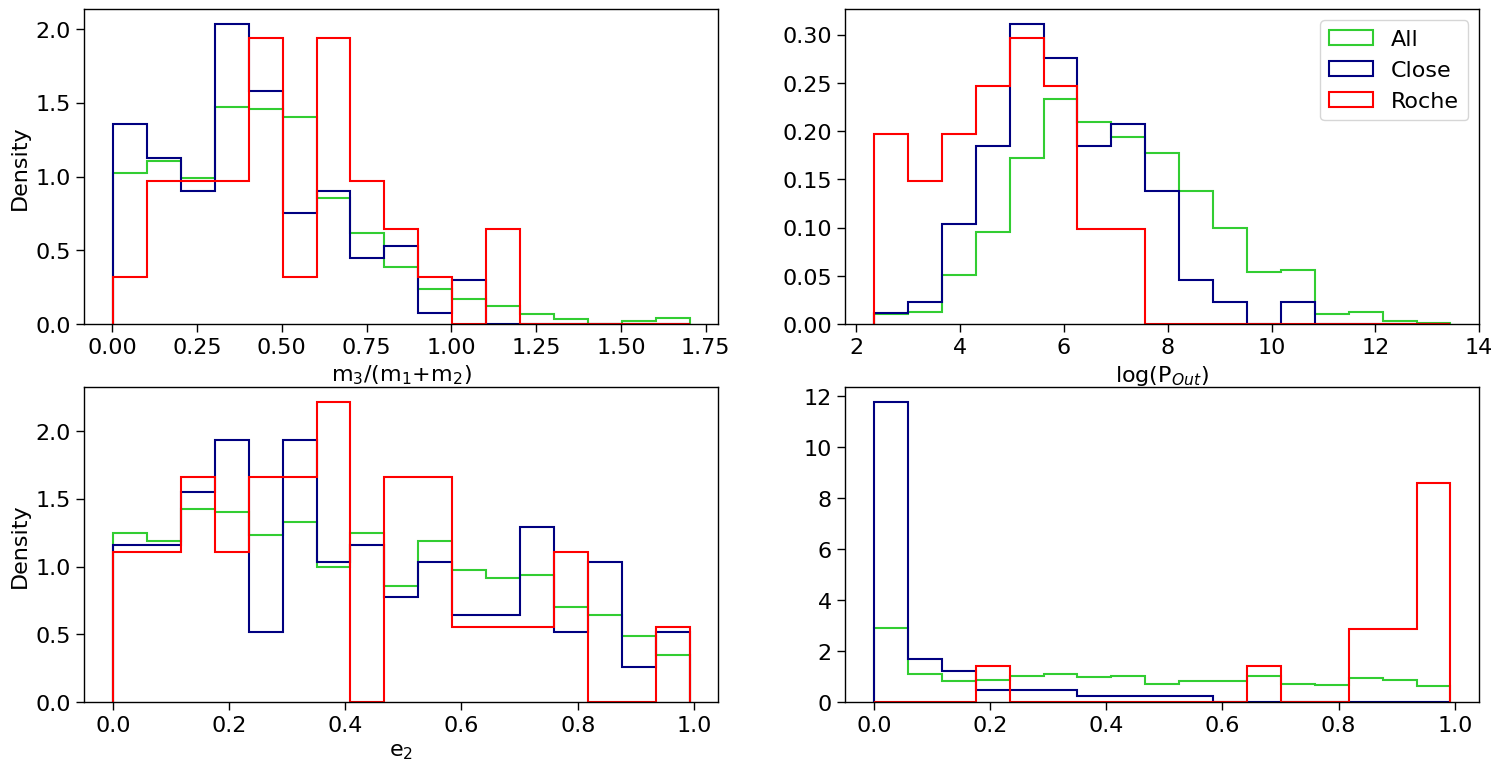

In [607]:
plot_all_vs_other(df_final7,close_df_final7,merged_df_final7,saveFig=True)

In [ ]:
#plot_all_vs_other(df_final7,close_df_final7,merged_df_final7)

y1 = np.log10(df_final7['P_out'])
y2 = np.log10(close_df_final7['P_out'])
y3 = np.log10(merged_df_final7['P_out'])

bins_P = np.linspace(  np.min(np.concatenate((y1,y2,y3))),np.max(np.concatenate((y1,y2,y3))), 18   )

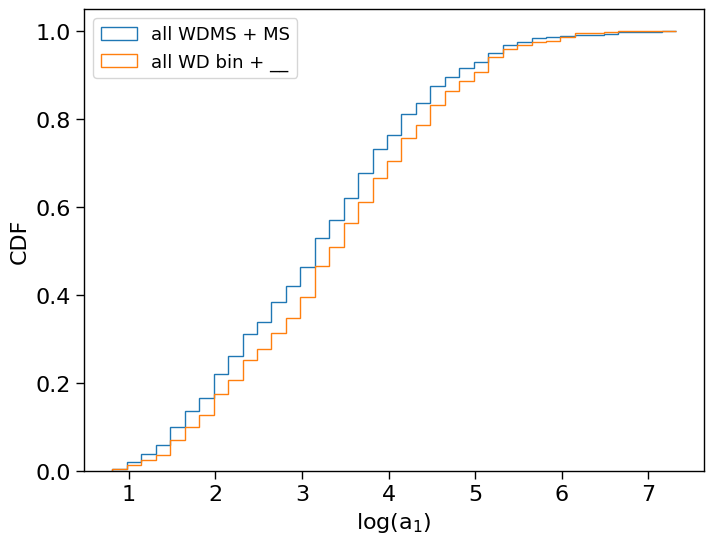

In [ ]:

fig,ax = plt.subplots()
dist1 = np.log10(WDMS7.query("(type3 == 0 or type3 == 1) ")['a2'])
dist2 = np.log10(WDMS7.query("flag == 'END' ")['a2'])

bins = np.linspace(np.min(dist1), np.max(dist1), 40)
_,_, patches1 = ax.hist(dist1,bins=bins,cumulative=True,histtype='step',density=True,label = 'all WDMS + MS')
_,_, patches2 =ax.hist(dist2,bins=bins,cumulative=True,histtype='step',density=True,label = 'all WD bin + __')
patches1[0].set_xy(patches1[0].get_xy()[:-1])
patches2[0].set_xy(patches2[0].get_xy()[:-1])

ax.set_xlabel('log(a$_1$)')
ax.set_ylabel('CDF')

ax.legend(loc=2,fontsize=13)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


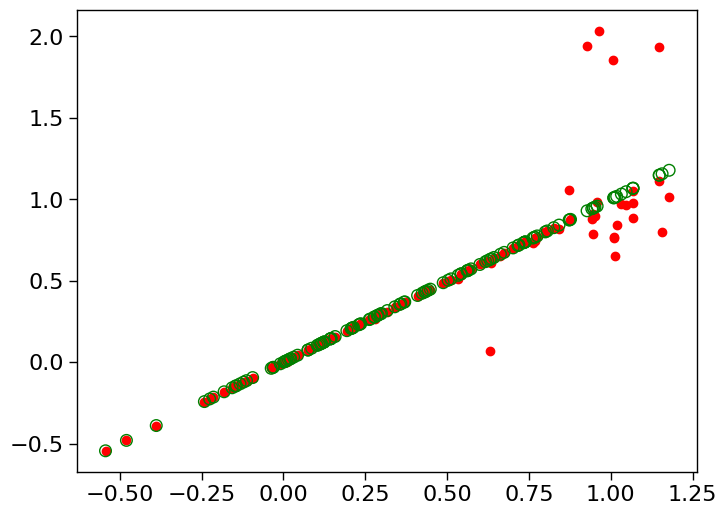

In [ ]:
#close_df_final = close_df_final[close_df_final['P_in']<10]
#(close_df_final['Spin1P'] <= 1.10*close_df_final['P_in']) & (close_df_final['Spin1P'] >=0.9*close_df_final['P_in']) 
#x = np.linspace(np.min(close_df_final['P_in']),np.max(close_df_final['P_in']),1000)
#plt.plot(x,x)

plt.scatter(np.log10(close_df_final7['P_in']),np.log10(close_df_final7['Spin2P']),c='r')
#plt.scatter(close_df_final['P_in'],close_df_final['Omega_p2'],c='g')
plt.scatter(np.log10(close_df_final7['P_in']),np.log10(close_df_final7['Omega_p2']),facecolors='none', edgecolors='g',s=70)

# Storing Disc.'s (NOT NEEDED)

In [ ]:
%%time
full_outputs_directory = '/Users/bijan1339/Desktop/Research/Outputs/'
tdis_all=[]
tdis2,tdis3,tdis4,tdis5,tdis6=[],[],[],[],[]
tMS=[]
tWD=[]
tRG = []
tdis_df = pd.DataFrame(columns=df_columns)
looking_for=['[2]','[3]','[4]','[5]','[6]']


for filename in os.listdir(full_outputs_directory):

    n = maybe_float(filename.split('_')[-1].split('.')[0] )
    full_path = full_outputs_directory + filename
    #this_file = open(full_path)
    #matching_lines = [line for line in this_file.readlines() if ('tdis' in line) or ('WD' in line)]
    
    MS_count = 0
    RG_count = 0
    WD_count = 0
    matching_lines=[]
    if  type(n) == float and 1000 < n < 2000:
        with open(full_path) as this_file:
            for line in this_file:
                this_flag = line.rsplit('\t',1)[-1].strip()
                if 'tdis' in this_flag:
                    matching_lines.append(line)
                if 'MS' in this_flag and MS_count == 0:
                    matching_lines.append(line)
                    MS_count+=1
                if 'RG' in this_flag and RG_count == 0:
                    matching_lines.append(line)
                    RG_count+=1
                if 'WD' in this_flag and WD_count == 0:
                    matching_lines.append(line)
                    WD_count+=1

    #     for line in this_file:
    #         print(line)
    #         break
    #         if ('tdis' in line) or ('WD' in line):
    #             matching_lines.append(line)
    #     WD_count = 0
    #     for l in this_file.readlines():
    #         #if '2564' in filename: print('y')
    #         if 'WD' in l and WD_count == 0:
    #             print('First WD!')
    #             WD_count+=1
    #             matching_lines.append(l) #get first instance of WD printout

        for line in matching_lines:
            line = [x.strip() for x in line.split('\t')]
            this_t = float(line[2])
            tdis_all.append(this_t)


            if '[2]' in line[-1]: tdis2.append(this_t)
            if '[3]' in line[-1]: tdis3.append(this_t)
            if '[4]' in line[-1]: tdis4.append(this_t)
            if '[5]' in line[-1]: tdis5.append(this_t)
            if '[6]' in line[-1]: tdis6.append(this_t)
            if 'MS' in line[-1]: tMS.append(this_t)
            if 'RG' in line[-1]: tRG.append(this_t)
            if 'WD' in line[-1]: tWD.append(this_t) 
            try:
                tdis_df.loc[len(tdis_df)]=[n]+line
            except ValueError:
                continue
#     this_file.close()
for i in range(1,len(tdis_df.columns)-1):tdis_df.iloc[:, i] = tdis_df.iloc[:, i].astype(float)  

CPU times: user 33 s, sys: 4.56 s, total: 37.5 s
Wall time: 39.6 s


/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_1048/538222405.py:28: RuntimeWarning: invalid value encountered in log10
  n_all, b_all,p_all = ax9.hist(np.log10(tdis_all),histtype='step',linewidth=1.5,color='b',bins=bins)
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_1048/538222405.py:30: RuntimeWarning: invalid value encountered in log10
  ax1.text(np.min(np.log10(tMS)),np.max(n1)*0.8,'tMS1',fontsize=16, color = 'r')
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_1048/538222405.py:31: RuntimeWarning: invalid value encountered in log10
  ax1.text(np.min(np.log10(tMS)),np.max(n1)*0.7,'tMS2',fontsize=16, color = 'g')
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_1048/538222405.py:32: RuntimeWarning: invalid value encountered in log10
  ax1.text(np.min(np.log10(tMS)),np.max(n1)*0.6,'tMS3',fontsize=16, color = 'b')
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_1048/538222405.py:40: RuntimeWarning: invalid value encountered in l

Text(0.5, 0.98, 'Discontinuity Times')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


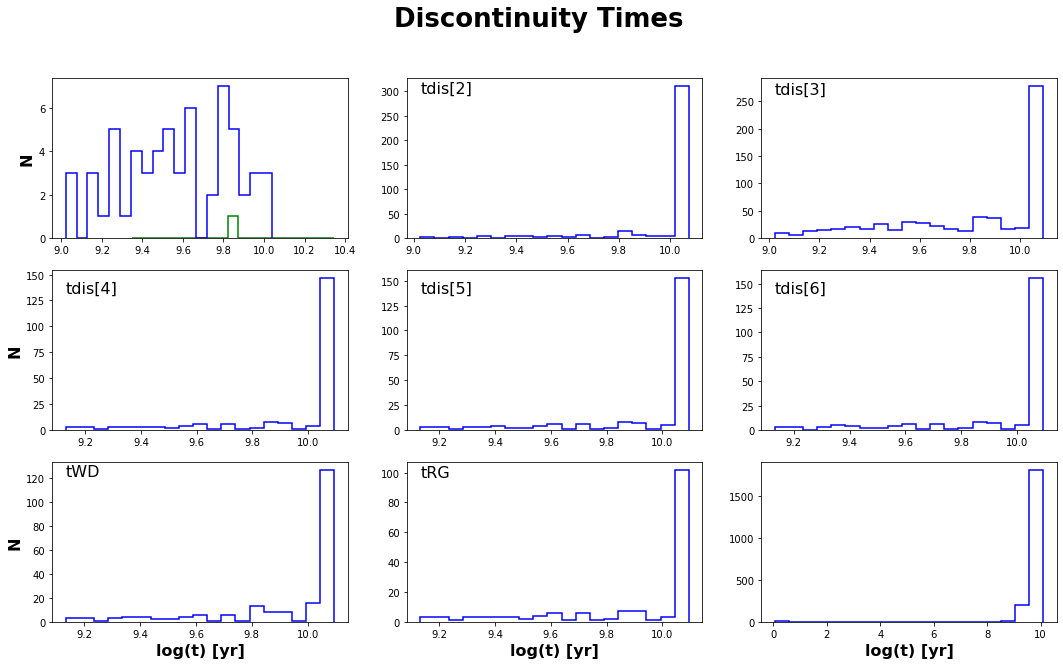

In [ ]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(18, 10))

tMS1 = tdis_df[tdis_df['flag'].str.contains('MS1')]['t'].astype(float)
tMS2 = tdis_df[tdis_df['flag'].str.contains('MS2')]['t'].astype(float)
tMS3 = tdis_df[tdis_df['flag'].str.contains('MS3')]['t'].astype(float)
tRG = tdis_df[tdis_df['flag'].str.contains('RG')]['t'].astype(float)
tWD = tdis_df[tdis_df['flag'].str.contains('WD')]['t'].astype(float)
tdis2 = tdis_df[tdis_df['flag'].str.contains('[2]')]['t'].astype(float)
tdis3 = tdis_df[tdis_df['flag'].str.contains('[3]')]['t'].astype(float)
tdis4 = tdis_df[tdis_df['flag'].str.contains('[4]')]['t'].astype(float)
tdis5 = tdis_df[tdis_df['flag'].str.contains('[5]')]['t'].astype(float)
tdis6 = tdis_df[tdis_df['flag'].str.contains('[6]')]['t'].astype(float)

#bins = np.linspace(0,np.max(np.log10(tdis6)),14)
bins=19
#n1, b1,p1 = ax1.hist(np.log10(tMS1),histtype='step',linewidth=1.5,color='r',bins=bins)
ax1.hist(np.log10(tMS2),histtype='step',linewidth=1.5,color='g',bins=bins)
ax1.hist(np.log10(tMS3),histtype='step',linewidth=1.5,color='b',bins=bins)

#n1, b1,p1 = ax1.hist(np.log10(tMS),histtype='step',linewidth=1.5,color='b',bins=bins)
n2, b2,p2 = ax2.hist(np.log10(tdis2),histtype='step',linewidth=1.5,color='b',bins=bins)
n3, b3,p3 = ax3.hist(np.log10(tdis3),histtype='step',linewidth=1.5,color='b',bins=bins)
n4, b4,p4 = ax4.hist(np.log10(tdis4),histtype='step',linewidth=1.5,color='b',bins=bins)
n5, b5,p5 = ax5.hist(np.log10(tdis5),histtype='step',linewidth=1.5,color='b',bins=bins)
n6, b6,p6 = ax6.hist(np.log10(tdis6),histtype='step',linewidth=1.5,color='b',bins=bins)
n_wd, b_wd,p_wd = ax7.hist(np.log10(tWD),histtype='step',linewidth=1.5,color='b',bins=bins)
n_rg, b_rg,p_rg = ax8.hist(np.log10(tRG),histtype='step',linewidth=1.5,color='b',bins=bins)
n_all, b_all,p_all = ax9.hist(np.log10(tdis_all),histtype='step',linewidth=1.5,color='b',bins=bins)

ax1.text(np.min(np.log10(tMS)),np.max(n1)*0.8,'tMS1',fontsize=16, color = 'r')
ax1.text(np.min(np.log10(tMS)),np.max(n1)*0.7,'tMS2',fontsize=16, color = 'g')
ax1.text(np.min(np.log10(tMS)),np.max(n1)*0.6,'tMS3',fontsize=16, color = 'b')
ax2.text(np.min(np.log10(tdis2)),np.max(n2)-15,'tdis[2]',fontsize=16)
ax3.text(np.min(np.log10(tdis3)),np.max(n3)-15,'tdis[3]',fontsize=16)
ax4.text(np.min(np.log10(tdis4)),np.max(n4)-15,'tdis[4]',fontsize=16)
ax5.text(np.min(np.log10(tdis5)),np.max(n5)-15,'tdis[5]',fontsize=16)
ax6.text(np.min(np.log10(tdis6)),np.max(n6)-15,'tdis[6]',fontsize=16)
ax7.text(np.min(np.log10(tWD)),np.max(n_wd)-5,'tWD',fontsize=16)
ax8.text(np.min(np.log10(tRG)),np.max(n_rg)-5,'tRG',fontsize=16)
ax9.text(np.min(np.log10(tdis_all)),np.max(n_all)-30,'All tdis',fontsize=16)

ax7.set_xlabel('log(t) [yr]',fontsize=16,fontweight='bold')
ax8.set_xlabel('log(t) [yr]',fontsize=16,fontweight='bold')
ax9.set_xlabel('log(t) [yr]',fontsize=16,fontweight='bold')

ax1.set_ylabel('N',fontsize=16,fontweight='bold')
ax4.set_ylabel('N',fontsize=16,fontweight='bold')
ax7.set_ylabel('N',fontsize=16,fontweight='bold')

fig.suptitle('Discontinuity Times',fontsize=26,fontweight='bold')

In [ ]:
tdis_df[tdis_df['type1']==5.]

,N,sur,sur2,t,e1,e2,g1,g2,a1,i1,i2,i,spin1h,spintot,beta,vp,spin1e,spin1q,spin2e,spin2q,spin2h,htot,m1,R1,m2,R2,a2,m3,Roche1,R1_pow,type1,type2,type3,beta2,gamma,gamma2,flag
20,1073.0,1.0,2.0,1.245869e+10,0.689649,0.425895,2.323961,1.244506,306.935000,81.16144,7.614039,88.77548,-6.632927e-07,0.000672,90.056590,88.77548,4.532184e-04,-4.955867e-04,0.307307,-11.933840,-25.433720,77.55369,0.724661,0.111260,0.221900,0.001152,40823.2900,0.0921,0.202703,0.068603,5.0,0.0,0.0,154.856100,47.55681,88.52491,RG
60,1477.0,1.0,2.0,1.245868e+10,0.731966,0.141365,-2.341839,-2.144731,30.022780,151.13530,4.184579,155.31990,2.801600e-02,0.042840,49.158280,155.31990,3.322742e-03,3.223833e-02,100.048900,27.950240,74.922670,24.85729,0.724668,0.111142,0.398300,0.001751,287.1648,0.4543,0.214357,0.078673,5.0,0.0,0.0,54.199190,84.11541,15.60854,RG
64,1463.0,1.0,2.0,1.245869e+10,0.003669,0.180963,-1.874312,0.083981,4.999032,67.02503,0.156887,67.18194,7.237124e-03,0.007237,0.002006,67.18194,1.359250e-07,2.137958e-07,0.017916,-0.018882,16.574980,13.37178,0.724661,0.111260,0.181361,0.001002,25148.9500,0.9003,0.199767,0.065084,5.0,0.0,1.0,0.089977,57.55302,46.50364,RG
108,1476.0,1.0,2.0,1.245868e+10,0.172646,0.200982,-1.458133,2.930971,680.672600,83.35599,9.666180,93.02217,1.081888e-04,0.001219,84.908080,93.02217,-7.481157e-04,-9.563070e-04,-6.469388,-24.237220,-6.431062,156.53160,0.724666,0.111171,0.215161,0.001128,5792.3650,0.4046,0.202059,0.068009,5.0,0.0,0.0,104.378800,128.03600,104.94490,RG
116,1270.0,1.0,2.0,1.245869e+10,0.592336,0.833958,2.630469,-0.519577,22.401350,132.62740,2.424995,135.05240,4.992736e-02,0.049940,1.295348,135.05240,6.176055e-04,-9.450409e-04,4.300884,15.621690,7.240248,22.86713,0.724661,0.111260,0.186200,0.001021,2505.6210,0.4340,0.200122,0.065542,5.0,0.0,0.0,65.922610,56.83448,74.60698,RG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,1490.0,1.0,2.0,1.245868e+10,0.829290,0.384143,-1.313684,-0.982968,134.452700,126.81760,3.703034,130.52070,4.783234e-04,0.000673,44.734510,130.52070,3.535649e-04,3.155686e-04,6.241844,9.949943,26.685400,39.67704,0.724668,0.111143,0.225079,0.001163,735.8707,0.7331,0.202715,0.068779,5.0,0.0,1.0,23.756960,41.74999,57.89894,RG
1939,1136.0,1.0,2.0,1.245869e+10,0.779389,0.554950,-1.009218,-0.879293,33.336870,55.54133,2.549336,58.09067,2.824908e-02,0.031168,24.995150,58.09067,4.710374e-04,1.316143e-02,-265.422600,252.522100,-88.475990,26.54357,0.724661,0.111260,0.639092,0.002871,1730.7970,0.7891,0.228941,0.086420,5.0,0.0,1.0,103.577100,87.95030,136.42680,RG
1946,1485.0,1.0,2.0,1.246000e+10,0.209591,0.644463,1.727362,-0.126706,12.680140,64.07451,0.834909,64.90942,7.706917e-02,0.077069,0.137338,64.90942,1.347812e-04,1.263367e-04,-95.501960,-1739.709000,234529.800000,24.41921,0.722919,0.141839,0.522998,0.000065,33193.6800,0.5507,0.283430,0.106202,5.0,11.0,11.0,0.425644,43.14771,93.14212,RG
1955,1297.0,1.0,2.0,1.245869e+10,0.591539,0.361847,-2.953459,-1.526041,76.237570,92.93408,3.430115,96.36420,-9.719061e-02,0.101723,162.832000,96.36420,-1.654788e-02,2.505464e-02,273.519100,-74.580110,196.011700,51.17038,0.724661,0.111260,0.613600,0.002739,5255.8400,0.6933,0.227505,0.085794,5.0,0.0,0.0,55.340490,123.44360,15.25200,RG


In [ ]:
# Account for all runs
# Restart those from the ones that never started
# Restart again from the new Cassini Runs (if they were not alr restarted)
# Restart the ones that didnt finish but were alr restarted once

In [ ]:
RG1_cond1 = ((tdis_df['type1'] == 5.) | (tdis_df['type1'] == 6.)) & (tdis_df['flag'].str.contains('tdis1')) 
RG1_cond2 = ((tdis_df['type2'] == 5.) | (tdis_df['type2'] == 6.)) & (tdis_df['flag'].str.contains('tdis2')) 
RG1_cond3 = ((tdis_df['type3'] == 5.) | (tdis_df['type2'] == 6.)) & (tdis_df['flag'].str.contains('tdis3')) 

WD_cond1 = ((tdis_df['type1'] == 11.) | (tdis_df['type1'] == 12.)) & (tdis_df['flag'].str.contains('WD')) 
WD_cond2 = ((tdis_df['type2'] == 11.) | (tdis_df['type2'] == 12.)) & (tdis_df['flag'].str.contains('WD')) 
WD_cond3 = ((tdis_df['type3'] == 11.) | (tdis_df['type2'] == 12.)) & (tdis_df['flag'].str.contains('WD')) 

typeis2_cond1 = (tdis_df['type1'] == 2.)  & (tdis_df['flag'].str.contains('tdis1'))
typeis2_cond2 = (tdis_df['type2'] == 2.)  & (tdis_df['flag'].str.contains('tdis2'))
typeis2_cond3 = (tdis_df['type3'] == 2.)  & (tdis_df['flag'].str.contains('tdis3'))

typeis3_cond1 = (tdis_df['type1'] == 3.)  & (tdis_df['flag'].str.contains('tdis1'))
typeis3_cond2 = (tdis_df['type2'] == 3.)  & (tdis_df['flag'].str.contains('tdis2'))
typeis3_cond3 = (tdis_df['type3'] == 3.)  & (tdis_df['flag'].str.contains('tdis3'))

typeis4_cond1 = (tdis_df['type1'] == 4.)  & (tdis_df['flag'].str.contains('tdis1'))
typeis4_cond2 = (tdis_df['type2'] == 4.)  & (tdis_df['flag'].str.contains('tdis2'))
typeis4_cond3 = (tdis_df['type3'] == 4.)  & (tdis_df['flag'].str.contains('tdis3'))

#get times
t_RG = tdis_df[(RG1_cond1) | (RG1_cond2) | (RG1_cond3)]['t']
t_WD = tdis_df[(WD_cond1) | (WD_cond2) | (WD_cond3)]['t']

t_typeis2 = tdis_df[(typeis2_cond1) | (typeis2_cond2) | (typeis2_cond3)]['t']
t_typeis3 = tdis_df[(typeis3_cond1) | (typeis3_cond2) | (typeis3_cond3)]['t']
t_typeis4 = tdis_df[(typeis4_cond1) | (typeis4_cond2) | (typeis4_cond3)]['t']



In [ ]:
#Close Binaries have low obliquities/eccentricities

88     1.332812e+08
129    1.455274e+08
Name: t, dtype: float64

In [ ]:
#close_df_final.groupby("sur")["type1"].count()
print(close_df_final["type1"].value_counts(),close_df_final["type2"].value_counts() )


1.0    69
3.0     3
2.0     3
Name: type1, dtype: int64 1.0    39
0.0    36
Name: type2, dtype: int64


In [ ]:
WD1 = (df_final['type1'] == 11. ) | (df_final['type1'] == 12.)
WD2 = (df_final['type2'] == 11. ) | (df_final['type2'] == 12.)
WD1_c = (close_df_final['type1'] == 11. ) | (close_df_final['type1'] == 12.)
WD2_c = (close_df_final['type2'] == 11. ) | (close_df_final['type2'] == 12.)
WDWD = df_final[WD1 & WD2]
WDWD_close = close_df_final[WD1_c & WD2_c]

(array([0.10584126, 0.11657878, 0.22855576, 0.18713962, 0.09203588,
        0.10737519, 0.11197698, 0.07669656, 0.04141614, 0.01380538]),
 array([-0.17618828,  0.74852049,  1.67322926,  2.59793803,  3.52264679,
         4.44735556,  5.37206433,  6.2967731 ,  7.22148187,  8.14619064,
         9.07089941]),
 [<matplotlib.patches.Polygon at 0x7feb2051ce50>])

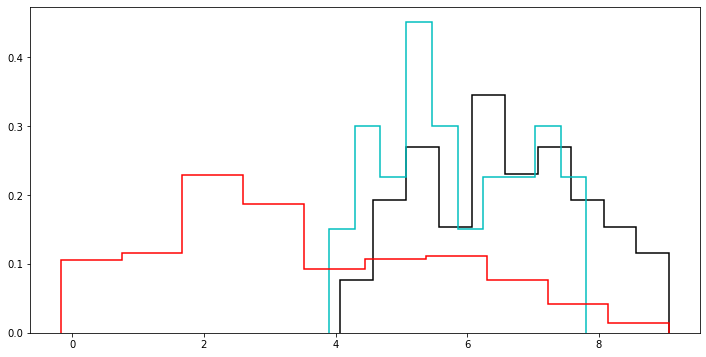

In [ ]:
plt.hist(np.log10(WDWD['P_in']),histtype='step',linewidth=1.5,color='black',density=True)
plt.hist(np.log10(WD_MS['P_in']),histtype='step',linewidth=1.5,color='c',density=True)

plt.hist(np.log10(df_final['P_in']),histtype='step',linewidth=1.5,color='red',density=True)

In [ ]:
#3 changing (EKL off)
m1i = 1.100000e-01
m2i = 1.100000e-01
m3i = 20.
a2i = 8.000000e+03
a1i = 1.000000e+02


m1f = 1.100000e-01
m2f = 1.100000e-01
m3f = 2.269600e+00
a2f = 7.641886e+04
a1f = 1.000000e+02


# 1 	 2 	 120000300.000000 	9.000000e-01 	 1.000000e-01 	 -5.356356e-01 	 -2.380343e+00 	 1.000000e+02 	  
# 9.987163e+00 	  1.283263e-02   	  1.000000e+01 	  4.307566e+00 	  4.779300e+00 	  2.567099e+01 	  0.000000e+00 	 
# 1.464176e+00   	  1.463820e+00 	  2.507550e-07 	  -4.224931e-07 	  4.779300e+00 	  1.284600e+01 	  1.100000e-01 	
# 6.661559e-04  	  1.100000e-01 	 6.661559e-04 	 7.641886e+04 	 2.269600e+00 	 1.398840e-03 	 5.287283e-04 	
# 0.000000 	 0.000000 	 13.000000 	 5.853177e-06 	 4.499303e+01 	 5.909677e+01 	 END

# 1 	 2 	 120000300.000000 	9.000000e-01 	 1.000000e-01 	 -5.356356e-01 	 -2.380343e+00 	 1.000000e+02 	
# 9.992709e+01 	  7.291122e-02   	  1.000000e+02 	  4.307566e+00 	  4.779300e+00 	  2.567099e+01 	  0.000000e+00 	 
# 1.464177e+00   	  1.463818e+00 	  1.426626e-06 	  -2.403700e-06 	  4.779300e+00 	  1.284600e+01 	  1.100000e-01 	
# 6.661559e-04  	  1.100000e-01 	 6.661559e-04 	 7.641886e+04 	 2.269600e+00 	 1.398840e-03 	 5.287283e-04 	
# 0.000000 	 0.000000 	 13.000000 	 3.350450e-05 	 4.499298e+01 	 5.930524e+01 	 END

In [ ]:
#1+3 changing
m1i = 2.000000e+01
m2i = 1.100000e-01
m3i = 5.000000e+00
a2i = 8.000000e+03
a1i = 1.000000e+02


m1f = 2.269597e+00
m2f = 1.100000e-01
m3f = 4.926137e+00
a2f = 2.773354e+04
a1f = 8.451011e+02

# 2 	 2 	 0.000000 	9.000000e-01 	 5.000000e-01 	 5.747428e+00 	 3.902843e+00 	 1.000000e+02 	  4.228244e+01 	
# 5.303452e-02   	  4.233548e+01 	  1.433873e+03 	  1.899065e-316 	  2.567099e+01 	  0.000000e+00 	  4.873256e+02   
# 4.873256e+02 	  0.000000e+00 	  0.000000e+00 	  4.779300e+00 	  1.228182e+02 	  2.000000e+01 	  2.789150e-02  	
# 1.100000e-01 	 6.661498e-04 	 8.000000e+03 	 5.000000e+00 	 0.000000e+00 	 4.914343e-03 	 1.000000 	 0.000000 
# 1.000000 	 0.000000e+00 	 4.500000e+01 	 4.500000e+01 	 FIRST

# 1 	 2 	 120000300.000000 	9.000000e-01 	 5.000000e-01 	 -5.279384e-01 	 -2.380343e+00 	 8.451011e+02 	
# 4.220927e+01 	  1.262081e-01   	  4.233548e+01 	  1.912347e+08 	  2.121454e+08 	  2.565301e+01 	  0.000000e+00 	 
# 6.561364e+07   	  6.426349e+07 	  3.074807e-03 	  -5.272745e-03 	  4.779296e+00 	  1.228182e+02 	  2.269597e+00 	  
# 6.508365e-08  	  1.100000e-01 	 6.661559e-04 	 2.773354e+04 	 4.926137e+00 	 1.101976e-07 	 2.335797e-08 	
# 13.000000 	 0.000000 	 4.000000 	 7.317424e-02 	 4.440439e+01 	 5.975136e+01 	 END

In [ ]:
print( (m1i+m2i+m3i)*a2i - (m1f+m2f+m3f)*a2f )
print( (m1i+m2i)*a1i - (m1f+m2f)*a1f )


-28492.39385600001
0.0


In [ ]:
#13
m1i = 2.032051e+01
m2i = 1.100000e-01
m3i = 2.000000e+01
a2i = 9.440055e+03
a1i = 6.739369e+01
Mi = m1i+m2i+m3i

m1f = 9.922626e+00
m2f = 1.100000e-01
m3f = 1.197969e+01  
a2f = 2.710173e+04
a1f = 1.372384e+02
Mf = m1f+m2f+m3f

dm1 = m1f-m1i
dm2 = m2f-m1f
dm3 = m3f-m3i

da1 = a1f-a1i
da2=a2f-a1f

In [ ]:
a2i*(dm1+dm3) + (m1i+m2i+m3i)*da2

916319.3829180461

In [ ]:
a2f*(dm1+dm3) + (m1f+m2f+m3f)*da2

94385.98900292558

In [ ]:
def get_final_periods(directory):
    #function to get final periods of all txt files in 'directory'
    #output in numpy array of logP in days

    for filename in os.listdir(directory):
        if filename.endswith('.txt') and filename.startswith('output'):
            this_file = os.path.join(directory, filename) #stores FULL filename

            first_line = get_first_line(this_file) #get first line
            last_line = get_last_line(this_file) #get last line
            
            N = filename.split('.txt')[0].split('_')[1] #get the output file number
            cut_folder = directory + 'cut_files/'
            if not os.path.isdir(cut_folder): #make cut_files directory if not alr there
                os.makedirs(cut_folder)
            with open(cut_folder+'first_last_{}.txt'.format(N), 'w') as f:
                f.write(first_line)
                f.write(last_line)

In [ ]:
#period of low mass binaries as a function of time -- El-Badry et al. 2022